In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 3
DATASET_VERSION = "07"

In [4]:
OOF_PATH = Path(f"../data/oof/lgbm-dart-bce-dsv{DATASET_VERSION}")
SUB_PATH = Path(f"../data/subs/lgbm-dart-bce-dsv{DATASET_VERSION}")
ART_PATH = Path(f"../artifacts/lgbm-dart-bce-dsv{DATASET_VERSION}")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
len(input_feats)

1662

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'boosting': 'dart',
    'objective': 'binary',
    'metric': 'None',
    'num_iterations': 4350,
    'num_leaves': 15,
    'learning_rate': 0.05,
    'max_bin': 63,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 1.0,
    'feature_fraction': 0.15,
    'lambda_l1': 5.996099571922015,
    'lambda_l2': 2.8900783163910697,
    'min_data_in_leaf': 1000,
    'path_smooth': 1.476306537276899,
    'min_gain_to_split': 0.313937968985787,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': True,
    'verbosity': -1,
    # dropout params
    'drop_rate': 0.1,
    'max_drop': 40,
    'skip_drop': 0.7,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
                
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            free_raw_data=True,
        )
                
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [10]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/3 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.755496	valid_0's recall_at4: 0.6094	valid_0's norm_gini: 0.901592


[100]	valid_0's amex_metric: 0.765743	valid_0's recall_at4: 0.624379	valid_0's norm_gini: 0.907106


[150]	valid_0's amex_metric: 0.771531	valid_0's recall_at4: 0.632164	valid_0's norm_gini: 0.910897


[200]	valid_0's amex_metric: 0.776388	valid_0's recall_at4: 0.638475	valid_0's norm_gini: 0.9143


[250]	valid_0's amex_metric: 0.78137	valid_0's recall_at4: 0.645965	valid_0's norm_gini: 0.916776


[300]	valid_0's amex_metric: 0.7852	valid_0's recall_at4: 0.652066	valid_0's norm_gini: 0.918333


[350]	valid_0's amex_metric: 0.787181	valid_0's recall_at4: 0.654759	valid_0's norm_gini: 0.919603


[400]	valid_0's amex_metric: 0.789394	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.920536


[450]	valid_0's amex_metric: 0.790918	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.92127


[500]	valid_0's amex_metric: 0.791228	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.921849


[550]	valid_0's amex_metric: 0.791936	valid_0's recall_at4: 0.661533	valid_0's norm_gini: 0.922339


[600]	valid_0's amex_metric: 0.792741	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.922687


[650]	valid_0's amex_metric: 0.793911	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.923049


[700]	valid_0's amex_metric: 0.794382	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.923359


[750]	valid_0's amex_metric: 0.794648	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.923596


[800]	valid_0's amex_metric: 0.795288	valid_0's recall_at4: 0.666793	valid_0's norm_gini: 0.923783


[850]	valid_0's amex_metric: 0.796512	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.924043


[900]	valid_0's amex_metric: 0.79669	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.924188


[950]	valid_0's amex_metric: 0.7967	valid_0's recall_at4: 0.669065	valid_0's norm_gini: 0.924336


[1000]	valid_0's amex_metric: 0.796835	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.92452


[1050]	valid_0's amex_metric: 0.796928	valid_0's recall_at4: 0.669107	valid_0's norm_gini: 0.924749


[1100]	valid_0's amex_metric: 0.797621	valid_0's recall_at4: 0.670285	valid_0's norm_gini: 0.924956


[1150]	valid_0's amex_metric: 0.797852	valid_0's recall_at4: 0.670622	valid_0's norm_gini: 0.925081


[1200]	valid_0's amex_metric: 0.798002	valid_0's recall_at4: 0.67079	valid_0's norm_gini: 0.925214


[1250]	valid_0's amex_metric: 0.797413	valid_0's recall_at4: 0.669528	valid_0's norm_gini: 0.925298


[1300]	valid_0's amex_metric: 0.797574	valid_0's recall_at4: 0.66978	valid_0's norm_gini: 0.925368


[1350]	valid_0's amex_metric: 0.797905	valid_0's recall_at4: 0.670412	valid_0's norm_gini: 0.925398


[1400]	valid_0's amex_metric: 0.79815	valid_0's recall_at4: 0.670832	valid_0's norm_gini: 0.925467


[1450]	valid_0's amex_metric: 0.798266	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.925532


[1500]	valid_0's amex_metric: 0.798586	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.925624


[1550]	valid_0's amex_metric: 0.798818	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925709


[1600]	valid_0's amex_metric: 0.799354	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.925773


[1650]	valid_0's amex_metric: 0.799298	valid_0's recall_at4: 0.672768	valid_0's norm_gini: 0.925828


[1700]	valid_0's amex_metric: 0.799103	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.925859


[1750]	valid_0's amex_metric: 0.799169	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.925907


[1800]	valid_0's amex_metric: 0.798521	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.925957


[1850]	valid_0's amex_metric: 0.798748	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.925991


[1900]	valid_0's amex_metric: 0.798512	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.926024


[1950]	valid_0's amex_metric: 0.79889	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926065


[2000]	valid_0's amex_metric: 0.799115	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.926093


[2050]	valid_0's amex_metric: 0.79924	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926133


[2100]	valid_0's amex_metric: 0.798513	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.926152


[2150]	valid_0's amex_metric: 0.798552	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.926188


[2200]	valid_0's amex_metric: 0.798641	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.926198


[2250]	valid_0's amex_metric: 0.798888	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.926185


[2300]	valid_0's amex_metric: 0.799151	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.926207


[2350]	valid_0's amex_metric: 0.799443	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.926201


[2400]	valid_0's amex_metric: 0.798781	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.926225


[2450]	valid_0's amex_metric: 0.799267	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.926229


[2500]	valid_0's amex_metric: 0.799141	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.926229


[2550]	valid_0's amex_metric: 0.799121	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926232


[2600]	valid_0's amex_metric: 0.798867	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.926228


[2650]	valid_0's amex_metric: 0.798988	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.92626


[2700]	valid_0's amex_metric: 0.799306	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926265


[2750]	valid_0's amex_metric: 0.799473	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.926263


[2800]	valid_0's amex_metric: 0.798574	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.926273


[2850]	valid_0's amex_metric: 0.798755	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.9263


[2900]	valid_0's amex_metric: 0.799192	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.926332


[2950]	valid_0's amex_metric: 0.798962	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.926334


[3000]	valid_0's amex_metric: 0.7988	valid_0's recall_at4: 0.671253	valid_0's norm_gini: 0.926346


[3050]	valid_0's amex_metric: 0.799136	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.926345


[3100]	valid_0's amex_metric: 0.799432	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.926348


[3150]	valid_0's amex_metric: 0.799263	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926347


[3200]	valid_0's amex_metric: 0.799261	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926344


[3250]	valid_0's amex_metric: 0.799244	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.926352


[3300]	valid_0's amex_metric: 0.799457	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926357


[3350]	valid_0's amex_metric: 0.79944	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.926364


[3400]	valid_0's amex_metric: 0.79919	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926369


[3450]	valid_0's amex_metric: 0.798706	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.926368


[3500]	valid_0's amex_metric: 0.7989	valid_0's recall_at4: 0.671421	valid_0's norm_gini: 0.926378


[3550]	valid_0's amex_metric: 0.799265	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.926393


[3600]	valid_0's amex_metric: 0.799456	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.926396


[3650]	valid_0's amex_metric: 0.799683	valid_0's recall_at4: 0.672978	valid_0's norm_gini: 0.926387


[3700]	valid_0's amex_metric: 0.799292	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926406


[3750]	valid_0's amex_metric: 0.800025	valid_0's recall_at4: 0.673651	valid_0's norm_gini: 0.926398


[3800]	valid_0's amex_metric: 0.799777	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.926407


[3850]	valid_0's amex_metric: 0.799737	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.926413


[3900]	valid_0's amex_metric: 0.799737	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.926412


[3950]	valid_0's amex_metric: 0.800034	valid_0's recall_at4: 0.673651	valid_0's norm_gini: 0.926417


[4000]	valid_0's amex_metric: 0.799992	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.926416


[4050]	valid_0's amex_metric: 0.799485	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926413


[4100]	valid_0's amex_metric: 0.799928	valid_0's recall_at4: 0.673441	valid_0's norm_gini: 0.926415


[4150]	valid_0's amex_metric: 0.800155	valid_0's recall_at4: 0.673904	valid_0's norm_gini: 0.926406


[4200]	valid_0's amex_metric: 0.800072	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.926409


[4250]	valid_0's amex_metric: 0.800197	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.926407


[4300]	valid_0's amex_metric: 0.800372	valid_0's recall_at4: 0.674325	valid_0's norm_gini: 0.92642


[4350]	valid_0's amex_metric: 0.800007	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.926405


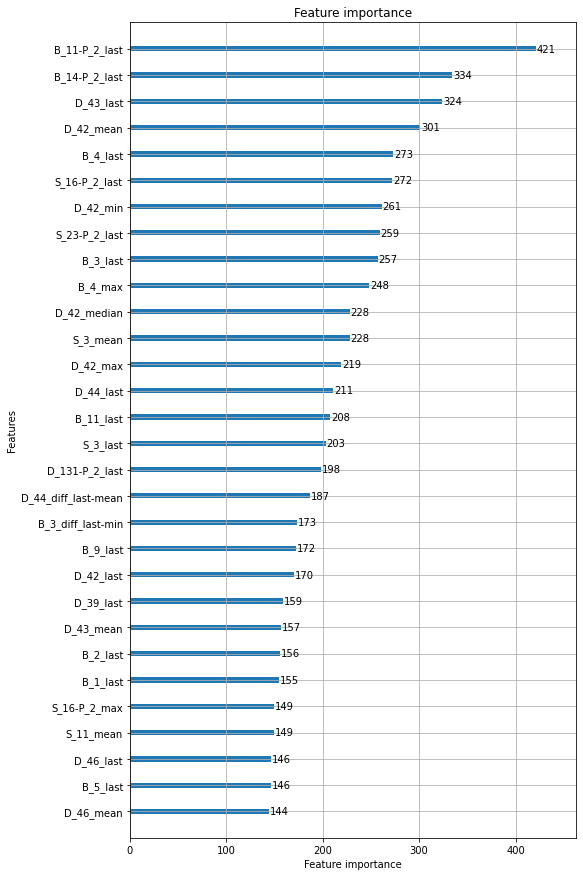

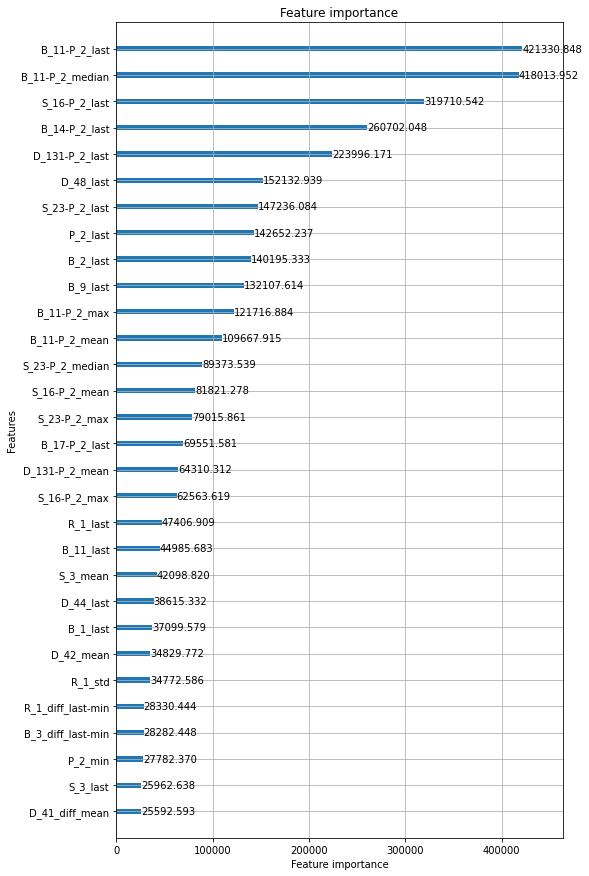

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.752176	valid_0's recall_at4: 0.603678	valid_0's norm_gini: 0.900674


[100]	valid_0's amex_metric: 0.761607	valid_0's recall_at4: 0.617226	valid_0's norm_gini: 0.905989


[150]	valid_0's amex_metric: 0.767486	valid_0's recall_at4: 0.625389	valid_0's norm_gini: 0.909582


[200]	valid_0's amex_metric: 0.773476	valid_0's recall_at4: 0.633847	valid_0's norm_gini: 0.913104


[250]	valid_0's amex_metric: 0.777925	valid_0's recall_at4: 0.640369	valid_0's norm_gini: 0.915481


[300]	valid_0's amex_metric: 0.781385	valid_0's recall_at4: 0.645628	valid_0's norm_gini: 0.917141


[350]	valid_0's amex_metric: 0.783826	valid_0's recall_at4: 0.649205	valid_0's norm_gini: 0.918447


[400]	valid_0's amex_metric: 0.787126	valid_0's recall_at4: 0.654801	valid_0's norm_gini: 0.919451


[450]	valid_0's amex_metric: 0.788062	valid_0's recall_at4: 0.655937	valid_0's norm_gini: 0.920187


[500]	valid_0's amex_metric: 0.790147	valid_0's recall_at4: 0.659598	valid_0's norm_gini: 0.920696


[550]	valid_0's amex_metric: 0.790588	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.9212


[600]	valid_0's amex_metric: 0.791402	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.921564


[650]	valid_0's amex_metric: 0.791352	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.921928


[700]	valid_0's amex_metric: 0.791765	valid_0's recall_at4: 0.661323	valid_0's norm_gini: 0.922207


[750]	valid_0's amex_metric: 0.792009	valid_0's recall_at4: 0.661533	valid_0's norm_gini: 0.922484


[800]	valid_0's amex_metric: 0.793097	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.922683


[850]	valid_0's amex_metric: 0.793294	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.92295


[900]	valid_0's amex_metric: 0.793743	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.923134


[950]	valid_0's amex_metric: 0.793456	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.923402


[1000]	valid_0's amex_metric: 0.793891	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.92364


[1050]	valid_0's amex_metric: 0.794511	valid_0's recall_at4: 0.665152	valid_0's norm_gini: 0.92387


[1100]	valid_0's amex_metric: 0.795653	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.924093


[1150]	valid_0's amex_metric: 0.795441	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924215


[1200]	valid_0's amex_metric: 0.795432	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.924365


[1250]	valid_0's amex_metric: 0.79562	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.924489


[1300]	valid_0's amex_metric: 0.795546	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.924594


[1350]	valid_0's amex_metric: 0.796091	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924675


[1400]	valid_0's amex_metric: 0.796449	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.924759


[1450]	valid_0's amex_metric: 0.796572	valid_0's recall_at4: 0.668308	valid_0's norm_gini: 0.924837


[1500]	valid_0's amex_metric: 0.79661	valid_0's recall_at4: 0.668308	valid_0's norm_gini: 0.924912


[1550]	valid_0's amex_metric: 0.796386	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.925012


[1600]	valid_0's amex_metric: 0.796749	valid_0's recall_at4: 0.668434	valid_0's norm_gini: 0.925064


[1650]	valid_0's amex_metric: 0.797266	valid_0's recall_at4: 0.669402	valid_0's norm_gini: 0.925131


[1700]	valid_0's amex_metric: 0.796851	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.925183


[1750]	valid_0's amex_metric: 0.79705	valid_0's recall_at4: 0.668855	valid_0's norm_gini: 0.925246


[1800]	valid_0's amex_metric: 0.797487	valid_0's recall_at4: 0.669654	valid_0's norm_gini: 0.925321


[1850]	valid_0's amex_metric: 0.797277	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925364


[1900]	valid_0's amex_metric: 0.797887	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.925404


[1950]	valid_0's amex_metric: 0.798143	valid_0's recall_at4: 0.670832	valid_0's norm_gini: 0.925453


[2000]	valid_0's amex_metric: 0.798251	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.925501


[2050]	valid_0's amex_metric: 0.798771	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.925532


[2100]	valid_0's amex_metric: 0.799129	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.925574


[2150]	valid_0's amex_metric: 0.799	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.925611


[2200]	valid_0's amex_metric: 0.798641	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.925608


[2250]	valid_0's amex_metric: 0.79869	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925664


[2300]	valid_0's amex_metric: 0.798543	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.925706


[2350]	valid_0's amex_metric: 0.798814	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.925744


[2400]	valid_0's amex_metric: 0.798685	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.925781


[2450]	valid_0's amex_metric: 0.799244	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.925803


[2500]	valid_0's amex_metric: 0.798472	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.925816


[2550]	valid_0's amex_metric: 0.798791	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.925825


[2600]	valid_0's amex_metric: 0.798826	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.925851


[2650]	valid_0's amex_metric: 0.798704	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.925859


[2700]	valid_0's amex_metric: 0.798797	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925879


[2750]	valid_0's amex_metric: 0.798828	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.925898


[2800]	valid_0's amex_metric: 0.798934	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.925899


[2850]	valid_0's amex_metric: 0.799475	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.925929


[2900]	valid_0's amex_metric: 0.799668	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.925937


[2950]	valid_0's amex_metric: 0.799255	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925952


[3000]	valid_0's amex_metric: 0.799623	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.925974


[3050]	valid_0's amex_metric: 0.799807	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.926004


[3100]	valid_0's amex_metric: 0.800087	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.926018


[3150]	valid_0's amex_metric: 0.800409	valid_0's recall_at4: 0.674788	valid_0's norm_gini: 0.926031


[3200]	valid_0's amex_metric: 0.800564	valid_0's recall_at4: 0.675082	valid_0's norm_gini: 0.926046


[3250]	valid_0's amex_metric: 0.800202	valid_0's recall_at4: 0.674367	valid_0's norm_gini: 0.926037


[3300]	valid_0's amex_metric: 0.800015	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.926042


[3350]	valid_0's amex_metric: 0.800184	valid_0's recall_at4: 0.674325	valid_0's norm_gini: 0.926043


[3400]	valid_0's amex_metric: 0.799804	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.926041


[3450]	valid_0's amex_metric: 0.799475	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.926056


[3500]	valid_0's amex_metric: 0.799703	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.92605


[3550]	valid_0's amex_metric: 0.800197	valid_0's recall_at4: 0.674325	valid_0's norm_gini: 0.926069


[3600]	valid_0's amex_metric: 0.799743	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926086


[3650]	valid_0's amex_metric: 0.800342	valid_0's recall_at4: 0.674619	valid_0's norm_gini: 0.926065


[3700]	valid_0's amex_metric: 0.800137	valid_0's recall_at4: 0.674198	valid_0's norm_gini: 0.926075


[3750]	valid_0's amex_metric: 0.800234	valid_0's recall_at4: 0.674409	valid_0's norm_gini: 0.92606


[3800]	valid_0's amex_metric: 0.799936	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.926052


[3850]	valid_0's amex_metric: 0.800049	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.926069


[3900]	valid_0's amex_metric: 0.800156	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926071


[3950]	valid_0's amex_metric: 0.800103	valid_0's recall_at4: 0.674114	valid_0's norm_gini: 0.926091


[4000]	valid_0's amex_metric: 0.800039	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.92609


[4050]	valid_0's amex_metric: 0.800018	valid_0's recall_at4: 0.673946	valid_0's norm_gini: 0.926089


[4100]	valid_0's amex_metric: 0.799714	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.926071


[4150]	valid_0's amex_metric: 0.799742	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926084


[4200]	valid_0's amex_metric: 0.7994	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.926074


[4250]	valid_0's amex_metric: 0.799592	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.926081


[4300]	valid_0's amex_metric: 0.799749	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926099


[4350]	valid_0's amex_metric: 0.799892	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.926091


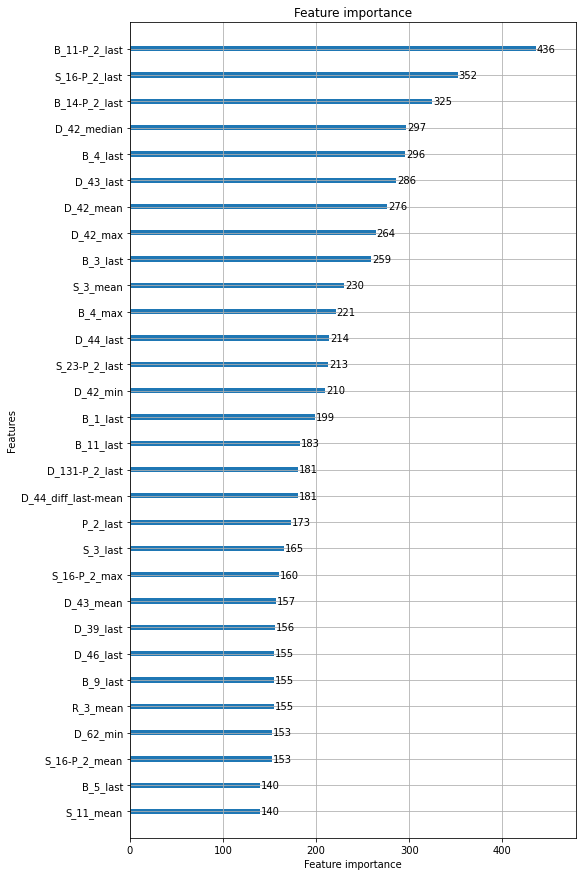

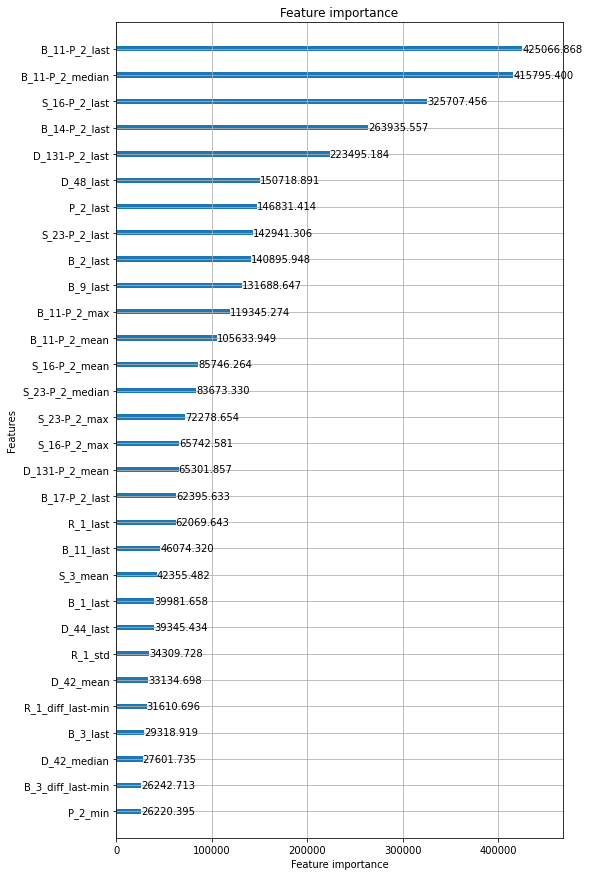

######################################## training model 3/5 ########################################


[50]	valid_0's amex_metric: 0.748753	valid_0's recall_at4: 0.597661	valid_0's norm_gini: 0.899846


[100]	valid_0's amex_metric: 0.758412	valid_0's recall_at4: 0.61163	valid_0's norm_gini: 0.905195


[150]	valid_0's amex_metric: 0.76367	valid_0's recall_at4: 0.618489	valid_0's norm_gini: 0.908851


[200]	valid_0's amex_metric: 0.76916	valid_0's recall_at4: 0.62602	valid_0's norm_gini: 0.9123


[250]	valid_0's amex_metric: 0.773917	valid_0's recall_at4: 0.633258	valid_0's norm_gini: 0.914577


[300]	valid_0's amex_metric: 0.778018	valid_0's recall_at4: 0.639822	valid_0's norm_gini: 0.916215


[350]	valid_0's amex_metric: 0.780261	valid_0's recall_at4: 0.643104	valid_0's norm_gini: 0.917418


[400]	valid_0's amex_metric: 0.782155	valid_0's recall_at4: 0.646007	valid_0's norm_gini: 0.918303


[450]	valid_0's amex_metric: 0.783709	valid_0's recall_at4: 0.648363	valid_0's norm_gini: 0.919056


[500]	valid_0's amex_metric: 0.785357	valid_0's recall_at4: 0.651098	valid_0's norm_gini: 0.919615


[550]	valid_0's amex_metric: 0.786128	valid_0's recall_at4: 0.652192	valid_0's norm_gini: 0.920064


[600]	valid_0's amex_metric: 0.786067	valid_0's recall_at4: 0.651771	valid_0's norm_gini: 0.920362


[650]	valid_0's amex_metric: 0.787171	valid_0's recall_at4: 0.653623	valid_0's norm_gini: 0.92072


[700]	valid_0's amex_metric: 0.788316	valid_0's recall_at4: 0.6556	valid_0's norm_gini: 0.921031


[750]	valid_0's amex_metric: 0.789057	valid_0's recall_at4: 0.656863	valid_0's norm_gini: 0.921251


[800]	valid_0's amex_metric: 0.789343	valid_0's recall_at4: 0.657241	valid_0's norm_gini: 0.921444


[850]	valid_0's amex_metric: 0.79004	valid_0's recall_at4: 0.658378	valid_0's norm_gini: 0.921702


[900]	valid_0's amex_metric: 0.789893	valid_0's recall_at4: 0.657873	valid_0's norm_gini: 0.921914


[950]	valid_0's amex_metric: 0.790303	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.922103


[1000]	valid_0's amex_metric: 0.789957	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.922294


[1050]	valid_0's amex_metric: 0.79052	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.922495


[1100]	valid_0's amex_metric: 0.790669	valid_0's recall_at4: 0.65863	valid_0's norm_gini: 0.922709


[1150]	valid_0's amex_metric: 0.790949	valid_0's recall_at4: 0.659051	valid_0's norm_gini: 0.922847


[1200]	valid_0's amex_metric: 0.791177	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.922967


[1250]	valid_0's amex_metric: 0.791275	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.923036


[1300]	valid_0's amex_metric: 0.79174	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.923124


[1350]	valid_0's amex_metric: 0.791828	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.923216


[1400]	valid_0's amex_metric: 0.792001	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.923311


[1450]	valid_0's amex_metric: 0.791948	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.923373


[1500]	valid_0's amex_metric: 0.792187	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.923472


[1550]	valid_0's amex_metric: 0.792231	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.923559


[1600]	valid_0's amex_metric: 0.79214	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.923631


[1650]	valid_0's amex_metric: 0.792232	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.923689


[1700]	valid_0's amex_metric: 0.792388	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.923748


[1750]	valid_0's amex_metric: 0.792693	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.92381


[1800]	valid_0's amex_metric: 0.792476	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.92384


[1850]	valid_0's amex_metric: 0.7923	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.923909


[1900]	valid_0's amex_metric: 0.79223	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.923937


[1950]	valid_0's amex_metric: 0.792565	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.924017


[2000]	valid_0's amex_metric: 0.793011	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.924068


[2050]	valid_0's amex_metric: 0.792979	valid_0's recall_at4: 0.66187	valid_0's norm_gini: 0.924089


[2100]	valid_0's amex_metric: 0.79287	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924122


[2150]	valid_0's amex_metric: 0.7932	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.924152


[2200]	valid_0's amex_metric: 0.793509	valid_0's recall_at4: 0.662838	valid_0's norm_gini: 0.92418


[2250]	valid_0's amex_metric: 0.793349	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.924197


[2300]	valid_0's amex_metric: 0.793247	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.924203


[2350]	valid_0's amex_metric: 0.792918	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924218


[2400]	valid_0's amex_metric: 0.793779	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924258


[2450]	valid_0's amex_metric: 0.793792	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924284


[2500]	valid_0's amex_metric: 0.793696	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.924301


[2550]	valid_0's amex_metric: 0.793308	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.924284


[2600]	valid_0's amex_metric: 0.793902	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.924293


[2650]	valid_0's amex_metric: 0.793784	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.92431


[2700]	valid_0's amex_metric: 0.793574	valid_0's recall_at4: 0.662838	valid_0's norm_gini: 0.924311


[2750]	valid_0's amex_metric: 0.793797	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.924336


[2800]	valid_0's amex_metric: 0.793821	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924342


[2850]	valid_0's amex_metric: 0.79376	valid_0's recall_at4: 0.663174	valid_0's norm_gini: 0.924346


[2900]	valid_0's amex_metric: 0.793579	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.924362


[2950]	valid_0's amex_metric: 0.793881	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.924378


[3000]	valid_0's amex_metric: 0.793693	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.924422


[3050]	valid_0's amex_metric: 0.793574	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.924436


[3100]	valid_0's amex_metric: 0.79357	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.924429


[3150]	valid_0's amex_metric: 0.794015	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.924435


[3200]	valid_0's amex_metric: 0.793786	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.92444


[3250]	valid_0's amex_metric: 0.794086	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.924451


[3300]	valid_0's amex_metric: 0.794508	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.924452


[3350]	valid_0's amex_metric: 0.794442	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.924447


[3400]	valid_0's amex_metric: 0.794015	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.924477


[3450]	valid_0's amex_metric: 0.794688	valid_0's recall_at4: 0.664899	valid_0's norm_gini: 0.924477


[3500]	valid_0's amex_metric: 0.794486	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.924493


[3550]	valid_0's amex_metric: 0.794407	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.924503


[3600]	valid_0's amex_metric: 0.793985	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.9245


[3650]	valid_0's amex_metric: 0.794019	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.924484


[3700]	valid_0's amex_metric: 0.7939	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.9245


[3750]	valid_0's amex_metric: 0.79375	valid_0's recall_at4: 0.663006	valid_0's norm_gini: 0.924495


[3800]	valid_0's amex_metric: 0.793745	valid_0's recall_at4: 0.663006	valid_0's norm_gini: 0.924483


[3850]	valid_0's amex_metric: 0.793479	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924499


[3900]	valid_0's amex_metric: 0.79344	valid_0's recall_at4: 0.662375	valid_0's norm_gini: 0.924505


[3950]	valid_0's amex_metric: 0.794053	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.924511


[4000]	valid_0's amex_metric: 0.794073	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.924509


[4050]	valid_0's amex_metric: 0.794095	valid_0's recall_at4: 0.663679	valid_0's norm_gini: 0.92451


[4100]	valid_0's amex_metric: 0.794228	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.924524


[4150]	valid_0's amex_metric: 0.794055	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.924515


[4200]	valid_0's amex_metric: 0.794001	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.924491


[4250]	valid_0's amex_metric: 0.793474	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.92449


[4300]	valid_0's amex_metric: 0.793193	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.924474


[4350]	valid_0's amex_metric: 0.793467	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924475


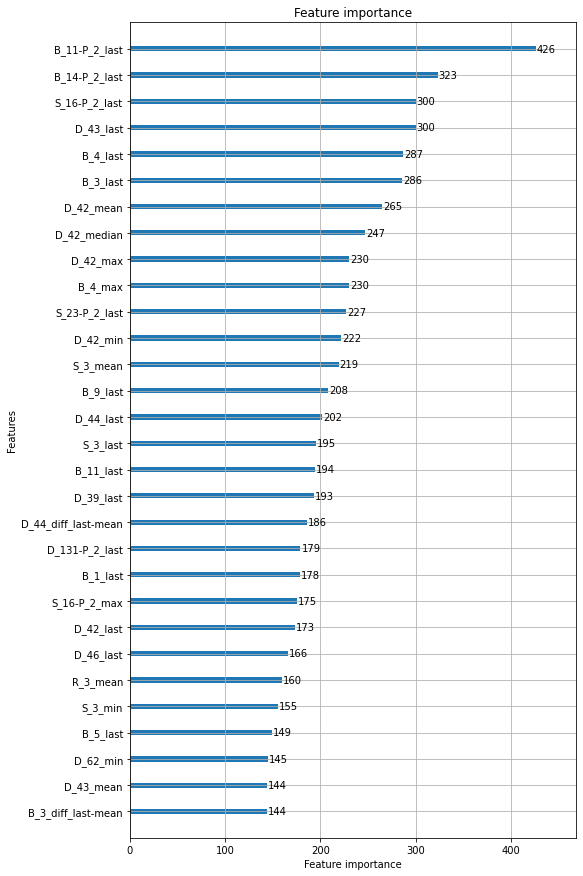

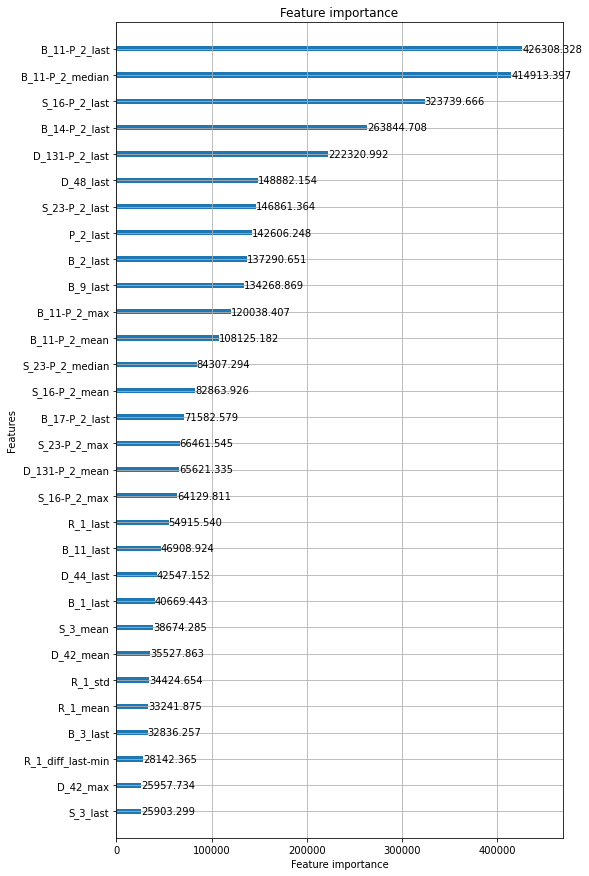

######################################## training model 4/5 ########################################


[50]	valid_0's amex_metric: 0.748424	valid_0's recall_at4: 0.59777	valid_0's norm_gini: 0.899077


[100]	valid_0's amex_metric: 0.758103	valid_0's recall_at4: 0.611445	valid_0's norm_gini: 0.90476


[150]	valid_0's amex_metric: 0.763624	valid_0's recall_at4: 0.618893	valid_0's norm_gini: 0.908355


[200]	valid_0's amex_metric: 0.771217	valid_0's recall_at4: 0.630381	valid_0's norm_gini: 0.912054


[250]	valid_0's amex_metric: 0.775067	valid_0's recall_at4: 0.635725	valid_0's norm_gini: 0.914408


[300]	valid_0's amex_metric: 0.778094	valid_0's recall_at4: 0.640059	valid_0's norm_gini: 0.916128


[350]	valid_0's amex_metric: 0.779549	valid_0's recall_at4: 0.6417	valid_0's norm_gini: 0.917397


[400]	valid_0's amex_metric: 0.781725	valid_0's recall_at4: 0.645024	valid_0's norm_gini: 0.918426


[450]	valid_0's amex_metric: 0.783128	valid_0's recall_at4: 0.647128	valid_0's norm_gini: 0.919129


[500]	valid_0's amex_metric: 0.784364	valid_0's recall_at4: 0.649022	valid_0's norm_gini: 0.919705


[550]	valid_0's amex_metric: 0.785475	valid_0's recall_at4: 0.650705	valid_0's norm_gini: 0.920245


[600]	valid_0's amex_metric: 0.785445	valid_0's recall_at4: 0.650368	valid_0's norm_gini: 0.920522


[650]	valid_0's amex_metric: 0.785695	valid_0's recall_at4: 0.650536	valid_0's norm_gini: 0.920853


[700]	valid_0's amex_metric: 0.786331	valid_0's recall_at4: 0.651462	valid_0's norm_gini: 0.921199


[750]	valid_0's amex_metric: 0.787116	valid_0's recall_at4: 0.652767	valid_0's norm_gini: 0.921464


[800]	valid_0's amex_metric: 0.787692	valid_0's recall_at4: 0.653692	valid_0's norm_gini: 0.921691


[850]	valid_0's amex_metric: 0.788666	valid_0's recall_at4: 0.655333	valid_0's norm_gini: 0.921999


[900]	valid_0's amex_metric: 0.788813	valid_0's recall_at4: 0.655418	valid_0's norm_gini: 0.922208


[950]	valid_0's amex_metric: 0.788781	valid_0's recall_at4: 0.655123	valid_0's norm_gini: 0.922438


[1000]	valid_0's amex_metric: 0.789674	valid_0's recall_at4: 0.65668	valid_0's norm_gini: 0.922668


[1050]	valid_0's amex_metric: 0.790281	valid_0's recall_at4: 0.657648	valid_0's norm_gini: 0.922915


[1100]	valid_0's amex_metric: 0.790284	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.92313


[1150]	valid_0's amex_metric: 0.790727	valid_0's recall_at4: 0.658153	valid_0's norm_gini: 0.923301


[1200]	valid_0's amex_metric: 0.791081	valid_0's recall_at4: 0.658742	valid_0's norm_gini: 0.92342


[1250]	valid_0's amex_metric: 0.791135	valid_0's recall_at4: 0.658742	valid_0's norm_gini: 0.923527


[1300]	valid_0's amex_metric: 0.791537	valid_0's recall_at4: 0.659457	valid_0's norm_gini: 0.923617


[1350]	valid_0's amex_metric: 0.791695	valid_0's recall_at4: 0.65971	valid_0's norm_gini: 0.923681


[1400]	valid_0's amex_metric: 0.791008	valid_0's recall_at4: 0.658237	valid_0's norm_gini: 0.92378


[1450]	valid_0's amex_metric: 0.791247	valid_0's recall_at4: 0.658616	valid_0's norm_gini: 0.923878


[1500]	valid_0's amex_metric: 0.791544	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.923967


[1550]	valid_0's amex_metric: 0.791973	valid_0's recall_at4: 0.659878	valid_0's norm_gini: 0.924068


[1600]	valid_0's amex_metric: 0.791255	valid_0's recall_at4: 0.658363	valid_0's norm_gini: 0.924146


[1650]	valid_0's amex_metric: 0.792239	valid_0's recall_at4: 0.660257	valid_0's norm_gini: 0.924222


[1700]	valid_0's amex_metric: 0.792306	valid_0's recall_at4: 0.660341	valid_0's norm_gini: 0.924271


[1750]	valid_0's amex_metric: 0.79214	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924318


[1800]	valid_0's amex_metric: 0.792161	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.92436


[1850]	valid_0's amex_metric: 0.792562	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.924404


[1900]	valid_0's amex_metric: 0.792653	valid_0's recall_at4: 0.660888	valid_0's norm_gini: 0.924418


[1950]	valid_0's amex_metric: 0.792701	valid_0's recall_at4: 0.660972	valid_0's norm_gini: 0.924431


[2000]	valid_0's amex_metric: 0.79281	valid_0's recall_at4: 0.66114	valid_0's norm_gini: 0.92448


[2050]	valid_0's amex_metric: 0.792466	valid_0's recall_at4: 0.660425	valid_0's norm_gini: 0.924507


[2100]	valid_0's amex_metric: 0.792817	valid_0's recall_at4: 0.661056	valid_0's norm_gini: 0.924578


[2150]	valid_0's amex_metric: 0.792703	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924602


[2200]	valid_0's amex_metric: 0.79228	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924598


[2250]	valid_0's amex_metric: 0.792701	valid_0's recall_at4: 0.660762	valid_0's norm_gini: 0.92464


[2300]	valid_0's amex_metric: 0.79268	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.92464


[2350]	valid_0's amex_metric: 0.792662	valid_0's recall_at4: 0.660635	valid_0's norm_gini: 0.924688


[2400]	valid_0's amex_metric: 0.792278	valid_0's recall_at4: 0.659836	valid_0's norm_gini: 0.92472


[2450]	valid_0's amex_metric: 0.792881	valid_0's recall_at4: 0.661014	valid_0's norm_gini: 0.924748


[2500]	valid_0's amex_metric: 0.792807	valid_0's recall_at4: 0.660846	valid_0's norm_gini: 0.924769


[2550]	valid_0's amex_metric: 0.793153	valid_0's recall_at4: 0.661519	valid_0's norm_gini: 0.924787


[2600]	valid_0's amex_metric: 0.792599	valid_0's recall_at4: 0.660383	valid_0's norm_gini: 0.924815


[2650]	valid_0's amex_metric: 0.79275	valid_0's recall_at4: 0.660677	valid_0's norm_gini: 0.924823


[2700]	valid_0's amex_metric: 0.792759	valid_0's recall_at4: 0.660677	valid_0's norm_gini: 0.924841


[2750]	valid_0's amex_metric: 0.792925	valid_0's recall_at4: 0.661014	valid_0's norm_gini: 0.924837


[2800]	valid_0's amex_metric: 0.792261	valid_0's recall_at4: 0.659668	valid_0's norm_gini: 0.924855


[2850]	valid_0's amex_metric: 0.791783	valid_0's recall_at4: 0.6587	valid_0's norm_gini: 0.924866


[2900]	valid_0's amex_metric: 0.792146	valid_0's recall_at4: 0.659415	valid_0's norm_gini: 0.924877


[2950]	valid_0's amex_metric: 0.792359	valid_0's recall_at4: 0.659836	valid_0's norm_gini: 0.924882


[3000]	valid_0's amex_metric: 0.792321	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.92489


[3050]	valid_0's amex_metric: 0.792218	valid_0's recall_at4: 0.659541	valid_0's norm_gini: 0.924895


[3100]	valid_0's amex_metric: 0.792658	valid_0's recall_at4: 0.660425	valid_0's norm_gini: 0.924892


[3150]	valid_0's amex_metric: 0.792436	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924911


[3200]	valid_0's amex_metric: 0.792	valid_0's recall_at4: 0.659078	valid_0's norm_gini: 0.924922


[3250]	valid_0's amex_metric: 0.792145	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.924917


[3300]	valid_0's amex_metric: 0.791688	valid_0's recall_at4: 0.658447	valid_0's norm_gini: 0.924929


[3350]	valid_0's amex_metric: 0.791919	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.924927


[3400]	valid_0's amex_metric: 0.79244	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924917


[3450]	valid_0's amex_metric: 0.792634	valid_0's recall_at4: 0.660341	valid_0's norm_gini: 0.924928


[3500]	valid_0's amex_metric: 0.792343	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.924934


[3550]	valid_0's amex_metric: 0.792785	valid_0's recall_at4: 0.660635	valid_0's norm_gini: 0.924934


[3600]	valid_0's amex_metric: 0.792947	valid_0's recall_at4: 0.66093	valid_0's norm_gini: 0.924965


[3650]	valid_0's amex_metric: 0.792633	valid_0's recall_at4: 0.660299	valid_0's norm_gini: 0.924967


[3700]	valid_0's amex_metric: 0.792299	valid_0's recall_at4: 0.659625	valid_0's norm_gini: 0.924972


[3750]	valid_0's amex_metric: 0.792576	valid_0's recall_at4: 0.660173	valid_0's norm_gini: 0.92498


[3800]	valid_0's amex_metric: 0.79268	valid_0's recall_at4: 0.660383	valid_0's norm_gini: 0.924978


[3850]	valid_0's amex_metric: 0.792501	valid_0's recall_at4: 0.660004	valid_0's norm_gini: 0.924997


[3900]	valid_0's amex_metric: 0.792456	valid_0's recall_at4: 0.65992	valid_0's norm_gini: 0.924992


[3950]	valid_0's amex_metric: 0.792381	valid_0's recall_at4: 0.659794	valid_0's norm_gini: 0.924968


[4000]	valid_0's amex_metric: 0.792687	valid_0's recall_at4: 0.660425	valid_0's norm_gini: 0.924949


[4050]	valid_0's amex_metric: 0.792739	valid_0's recall_at4: 0.660551	valid_0's norm_gini: 0.924928


[4100]	valid_0's amex_metric: 0.793099	valid_0's recall_at4: 0.661267	valid_0's norm_gini: 0.924931


[4150]	valid_0's amex_metric: 0.792645	valid_0's recall_at4: 0.660383	valid_0's norm_gini: 0.924908


[4200]	valid_0's amex_metric: 0.792432	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924902


[4250]	valid_0's amex_metric: 0.792736	valid_0's recall_at4: 0.660593	valid_0's norm_gini: 0.924879


[4300]	valid_0's amex_metric: 0.792308	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.924865


[4350]	valid_0's amex_metric: 0.792246	valid_0's recall_at4: 0.659625	valid_0's norm_gini: 0.924867


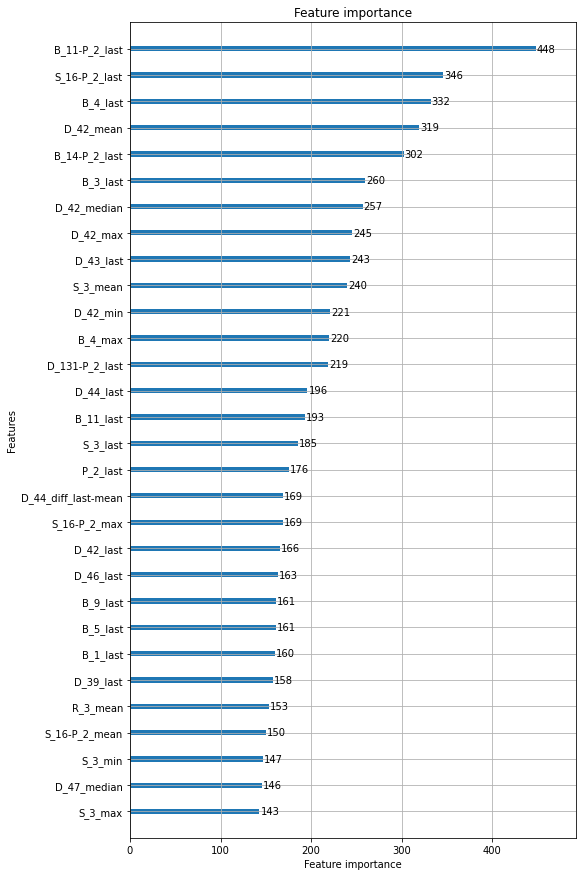

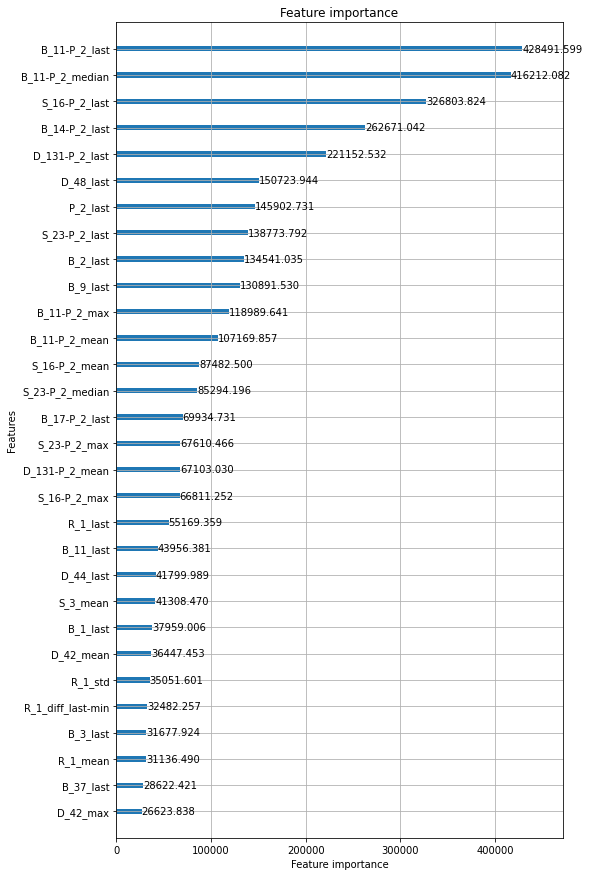

######################################## training model 5/5 ########################################


[50]	valid_0's amex_metric: 0.75533	valid_0's recall_at4: 0.607827	valid_0's norm_gini: 0.902832


[100]	valid_0's amex_metric: 0.765402	valid_0's recall_at4: 0.62268	valid_0's norm_gini: 0.908124


[150]	valid_0's amex_metric: 0.771827	valid_0's recall_at4: 0.631685	valid_0's norm_gini: 0.911968


[200]	valid_0's amex_metric: 0.77908	valid_0's recall_at4: 0.642542	valid_0's norm_gini: 0.915619


[250]	valid_0's amex_metric: 0.783195	valid_0's recall_at4: 0.64839	valid_0's norm_gini: 0.917999


[300]	valid_0's amex_metric: 0.78512	valid_0's recall_at4: 0.650705	valid_0's norm_gini: 0.919535


[350]	valid_0's amex_metric: 0.788124	valid_0's recall_at4: 0.655418	valid_0's norm_gini: 0.92083


[400]	valid_0's amex_metric: 0.79001	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.921741


[450]	valid_0's amex_metric: 0.790994	valid_0's recall_at4: 0.659541	valid_0's norm_gini: 0.922447


[500]	valid_0's amex_metric: 0.792724	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.922961


[550]	valid_0's amex_metric: 0.793021	valid_0's recall_at4: 0.662571	valid_0's norm_gini: 0.923471


[600]	valid_0's amex_metric: 0.794175	valid_0's recall_at4: 0.664549	valid_0's norm_gini: 0.923802


[650]	valid_0's amex_metric: 0.795448	valid_0's recall_at4: 0.666779	valid_0's norm_gini: 0.924117


[700]	valid_0's amex_metric: 0.795931	valid_0's recall_at4: 0.667452	valid_0's norm_gini: 0.92441


[750]	valid_0's amex_metric: 0.795711	valid_0's recall_at4: 0.666779	valid_0's norm_gini: 0.924643


[800]	valid_0's amex_metric: 0.795805	valid_0's recall_at4: 0.666737	valid_0's norm_gini: 0.924874


[850]	valid_0's amex_metric: 0.79712	valid_0's recall_at4: 0.669093	valid_0's norm_gini: 0.925146


[900]	valid_0's amex_metric: 0.797033	valid_0's recall_at4: 0.668715	valid_0's norm_gini: 0.925351


[950]	valid_0's amex_metric: 0.797886	valid_0's recall_at4: 0.670187	valid_0's norm_gini: 0.925585


[1000]	valid_0's amex_metric: 0.797501	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925782


[1050]	valid_0's amex_metric: 0.798048	valid_0's recall_at4: 0.670103	valid_0's norm_gini: 0.925993


[1100]	valid_0's amex_metric: 0.798614	valid_0's recall_at4: 0.671029	valid_0's norm_gini: 0.9262


[1150]	valid_0's amex_metric: 0.799354	valid_0's recall_at4: 0.672375	valid_0's norm_gini: 0.926333


[1200]	valid_0's amex_metric: 0.799525	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.926465


[1250]	valid_0's amex_metric: 0.799169	valid_0's recall_at4: 0.671702	valid_0's norm_gini: 0.926635


[1300]	valid_0's amex_metric: 0.799904	valid_0's recall_at4: 0.673091	valid_0's norm_gini: 0.926718


[1350]	valid_0's amex_metric: 0.800005	valid_0's recall_at4: 0.673217	valid_0's norm_gini: 0.926793


[1400]	valid_0's amex_metric: 0.800176	valid_0's recall_at4: 0.673469	valid_0's norm_gini: 0.926883


[1450]	valid_0's amex_metric: 0.800396	valid_0's recall_at4: 0.673848	valid_0's norm_gini: 0.926944


[1500]	valid_0's amex_metric: 0.800641	valid_0's recall_at4: 0.674269	valid_0's norm_gini: 0.927012


[1550]	valid_0's amex_metric: 0.800683	valid_0's recall_at4: 0.674311	valid_0's norm_gini: 0.927055


[1600]	valid_0's amex_metric: 0.801524	valid_0's recall_at4: 0.67591	valid_0's norm_gini: 0.927138


[1650]	valid_0's amex_metric: 0.801169	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.927227


[1700]	valid_0's amex_metric: 0.801616	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.92728


[1750]	valid_0's amex_metric: 0.802114	valid_0's recall_at4: 0.676878	valid_0's norm_gini: 0.927351


[1800]	valid_0's amex_metric: 0.801652	valid_0's recall_at4: 0.67591	valid_0's norm_gini: 0.927395


[1850]	valid_0's amex_metric: 0.802204	valid_0's recall_at4: 0.676962	valid_0's norm_gini: 0.927446


[1900]	valid_0's amex_metric: 0.802135	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.927477


[1950]	valid_0's amex_metric: 0.801619	valid_0's recall_at4: 0.675742	valid_0's norm_gini: 0.927496


[2000]	valid_0's amex_metric: 0.802184	valid_0's recall_at4: 0.676836	valid_0's norm_gini: 0.927532


[2050]	valid_0's amex_metric: 0.802492	valid_0's recall_at4: 0.677425	valid_0's norm_gini: 0.927559


[2100]	valid_0's amex_metric: 0.80255	valid_0's recall_at4: 0.677509	valid_0's norm_gini: 0.927591


[2150]	valid_0's amex_metric: 0.802004	valid_0's recall_at4: 0.676373	valid_0's norm_gini: 0.927635


[2200]	valid_0's amex_metric: 0.802713	valid_0's recall_at4: 0.677761	valid_0's norm_gini: 0.927665


[2250]	valid_0's amex_metric: 0.802853	valid_0's recall_at4: 0.678014	valid_0's norm_gini: 0.927692


[2300]	valid_0's amex_metric: 0.802589	valid_0's recall_at4: 0.677467	valid_0's norm_gini: 0.927711


[2350]	valid_0's amex_metric: 0.802888	valid_0's recall_at4: 0.678056	valid_0's norm_gini: 0.92772


[2400]	valid_0's amex_metric: 0.802732	valid_0's recall_at4: 0.677719	valid_0's norm_gini: 0.927744


[2450]	valid_0's amex_metric: 0.802729	valid_0's recall_at4: 0.677677	valid_0's norm_gini: 0.927782


[2500]	valid_0's amex_metric: 0.802805	valid_0's recall_at4: 0.677804	valid_0's norm_gini: 0.927807


[2550]	valid_0's amex_metric: 0.803214	valid_0's recall_at4: 0.678603	valid_0's norm_gini: 0.927824


[2600]	valid_0's amex_metric: 0.802842	valid_0's recall_at4: 0.677846	valid_0's norm_gini: 0.927839


[2650]	valid_0's amex_metric: 0.803347	valid_0's recall_at4: 0.678813	valid_0's norm_gini: 0.927881


[2700]	valid_0's amex_metric: 0.803671	valid_0's recall_at4: 0.679445	valid_0's norm_gini: 0.927897


[2750]	valid_0's amex_metric: 0.803739	valid_0's recall_at4: 0.679571	valid_0's norm_gini: 0.927908


[2800]	valid_0's amex_metric: 0.80362	valid_0's recall_at4: 0.679318	valid_0's norm_gini: 0.927921


[2850]	valid_0's amex_metric: 0.803449	valid_0's recall_at4: 0.678982	valid_0's norm_gini: 0.927916


[2900]	valid_0's amex_metric: 0.803503	valid_0's recall_at4: 0.679066	valid_0's norm_gini: 0.927941


[2950]	valid_0's amex_metric: 0.803336	valid_0's recall_at4: 0.678729	valid_0's norm_gini: 0.927944


[3000]	valid_0's amex_metric: 0.80351	valid_0's recall_at4: 0.679066	valid_0's norm_gini: 0.927954


[3050]	valid_0's amex_metric: 0.803456	valid_0's recall_at4: 0.67894	valid_0's norm_gini: 0.927972


[3100]	valid_0's amex_metric: 0.80322	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.927963


[3150]	valid_0's amex_metric: 0.803054	valid_0's recall_at4: 0.67814	valid_0's norm_gini: 0.927969


[3200]	valid_0's amex_metric: 0.803031	valid_0's recall_at4: 0.678098	valid_0's norm_gini: 0.927963


[3250]	valid_0's amex_metric: 0.803067	valid_0's recall_at4: 0.678182	valid_0's norm_gini: 0.927952


[3300]	valid_0's amex_metric: 0.803572	valid_0's recall_at4: 0.67915	valid_0's norm_gini: 0.927993


[3350]	valid_0's amex_metric: 0.803397	valid_0's recall_at4: 0.678813	valid_0's norm_gini: 0.927981


[3400]	valid_0's amex_metric: 0.803181	valid_0's recall_at4: 0.678351	valid_0's norm_gini: 0.928011


[3450]	valid_0's amex_metric: 0.80362	valid_0's recall_at4: 0.679234	valid_0's norm_gini: 0.928005


[3500]	valid_0's amex_metric: 0.804159	valid_0's recall_at4: 0.680286	valid_0's norm_gini: 0.928031


[3550]	valid_0's amex_metric: 0.803893	valid_0's recall_at4: 0.679739	valid_0's norm_gini: 0.928047


[3600]	valid_0's amex_metric: 0.804103	valid_0's recall_at4: 0.68016	valid_0's norm_gini: 0.928046


[3650]	valid_0's amex_metric: 0.804113	valid_0's recall_at4: 0.68016	valid_0's norm_gini: 0.928065


[3700]	valid_0's amex_metric: 0.803725	valid_0's recall_at4: 0.67936	valid_0's norm_gini: 0.928089


[3750]	valid_0's amex_metric: 0.803887	valid_0's recall_at4: 0.679697	valid_0's norm_gini: 0.928076


[3800]	valid_0's amex_metric: 0.80455	valid_0's recall_at4: 0.681001	valid_0's norm_gini: 0.928098


[3850]	valid_0's amex_metric: 0.804552	valid_0's recall_at4: 0.681001	valid_0's norm_gini: 0.928102


[3900]	valid_0's amex_metric: 0.804611	valid_0's recall_at4: 0.681128	valid_0's norm_gini: 0.928094


[3950]	valid_0's amex_metric: 0.804346	valid_0's recall_at4: 0.680581	valid_0's norm_gini: 0.928112


[4000]	valid_0's amex_metric: 0.803977	valid_0's recall_at4: 0.679823	valid_0's norm_gini: 0.92813


[4050]	valid_0's amex_metric: 0.804031	valid_0's recall_at4: 0.67995	valid_0's norm_gini: 0.928112


[4100]	valid_0's amex_metric: 0.803758	valid_0's recall_at4: 0.679402	valid_0's norm_gini: 0.928113


[4150]	valid_0's amex_metric: 0.803717	valid_0's recall_at4: 0.679318	valid_0's norm_gini: 0.928116


[4200]	valid_0's amex_metric: 0.803998	valid_0's recall_at4: 0.679865	valid_0's norm_gini: 0.92813


[4250]	valid_0's amex_metric: 0.803661	valid_0's recall_at4: 0.679192	valid_0's norm_gini: 0.928129


[4300]	valid_0's amex_metric: 0.80363	valid_0's recall_at4: 0.679108	valid_0's norm_gini: 0.928151


[4350]	valid_0's amex_metric: 0.803554	valid_0's recall_at4: 0.67894	valid_0's norm_gini: 0.928167


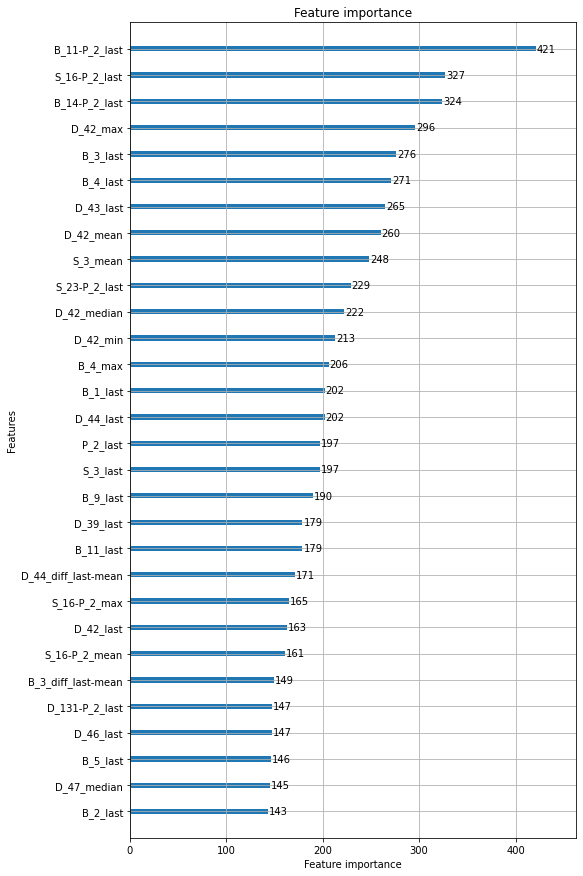

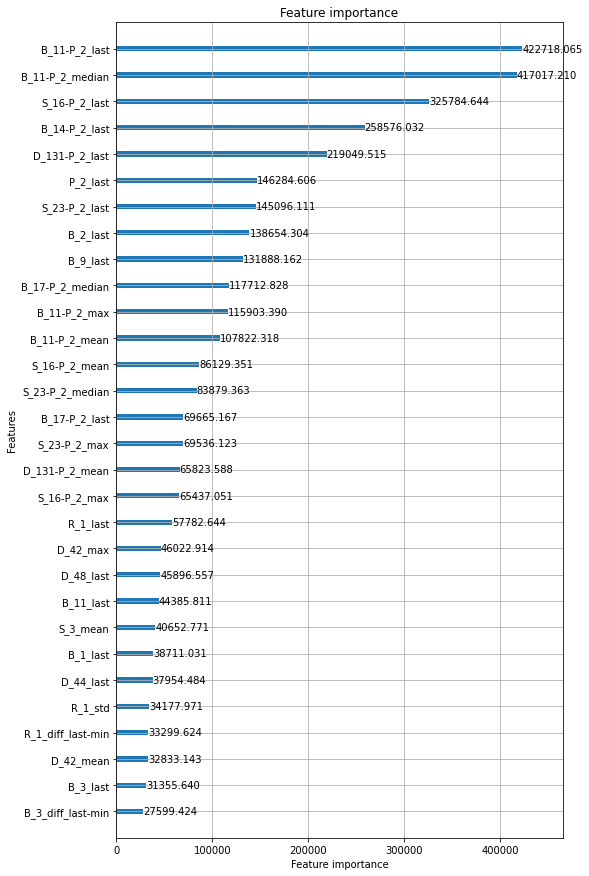

Training time: 48.01271374225617 min.


OOF recall_at4: 0.6698673713266233


OOF normalized_gini: 0.9258716019767044


OOF competition metric: 0.7978694866516638


############################### repeated cross-validation step: 2/3 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.754171	valid_0's recall_at4: 0.607086	valid_0's norm_gini: 0.901256


[100]	valid_0's amex_metric: 0.764235	valid_0's recall_at4: 0.621644	valid_0's norm_gini: 0.906826


[150]	valid_0's amex_metric: 0.770455	valid_0's recall_at4: 0.630186	valid_0's norm_gini: 0.910723


[200]	valid_0's amex_metric: 0.776419	valid_0's recall_at4: 0.638601	valid_0's norm_gini: 0.914237


[250]	valid_0's amex_metric: 0.780635	valid_0's recall_at4: 0.644702	valid_0's norm_gini: 0.916568


[300]	valid_0's amex_metric: 0.784356	valid_0's recall_at4: 0.650425	valid_0's norm_gini: 0.918287


[350]	valid_0's amex_metric: 0.786782	valid_0's recall_at4: 0.654002	valid_0's norm_gini: 0.919562


[400]	valid_0's amex_metric: 0.789216	valid_0's recall_at4: 0.657873	valid_0's norm_gini: 0.92056


[450]	valid_0's amex_metric: 0.791076	valid_0's recall_at4: 0.66086	valid_0's norm_gini: 0.921293


[500]	valid_0's amex_metric: 0.791696	valid_0's recall_at4: 0.661533	valid_0's norm_gini: 0.92186


[550]	valid_0's amex_metric: 0.793027	valid_0's recall_at4: 0.663679	valid_0's norm_gini: 0.922375


[600]	valid_0's amex_metric: 0.793655	valid_0's recall_at4: 0.664605	valid_0's norm_gini: 0.922705


[650]	valid_0's amex_metric: 0.794614	valid_0's recall_at4: 0.666162	valid_0's norm_gini: 0.923066


[700]	valid_0's amex_metric: 0.794593	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.92336


[750]	valid_0's amex_metric: 0.795571	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.923633


[800]	valid_0's amex_metric: 0.795765	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.923854


[850]	valid_0's amex_metric: 0.796313	valid_0's recall_at4: 0.668476	valid_0's norm_gini: 0.924151


[900]	valid_0's amex_metric: 0.796339	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.924328


[950]	valid_0's amex_metric: 0.797085	valid_0's recall_at4: 0.669654	valid_0's norm_gini: 0.924516


[1000]	valid_0's amex_metric: 0.797377	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.924722


[1050]	valid_0's amex_metric: 0.797659	valid_0's recall_at4: 0.670412	valid_0's norm_gini: 0.924906


[1100]	valid_0's amex_metric: 0.798621	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.925148


[1150]	valid_0's amex_metric: 0.798933	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925309


[1200]	valid_0's amex_metric: 0.799316	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.925443


[1250]	valid_0's amex_metric: 0.799117	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.92555


[1300]	valid_0's amex_metric: 0.799891	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.925626


[1350]	valid_0's amex_metric: 0.800106	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.925676


[1400]	valid_0's amex_metric: 0.800246	valid_0's recall_at4: 0.674745	valid_0's norm_gini: 0.925746


[1450]	valid_0's amex_metric: 0.800479	valid_0's recall_at4: 0.675124	valid_0's norm_gini: 0.925834


[1500]	valid_0's amex_metric: 0.800204	valid_0's recall_at4: 0.674493	valid_0's norm_gini: 0.925916


[1550]	valid_0's amex_metric: 0.800554	valid_0's recall_at4: 0.675124	valid_0's norm_gini: 0.925983


[1600]	valid_0's amex_metric: 0.800155	valid_0's recall_at4: 0.674283	valid_0's norm_gini: 0.926028


[1650]	valid_0's amex_metric: 0.800188	valid_0's recall_at4: 0.674283	valid_0's norm_gini: 0.926092


[1700]	valid_0's amex_metric: 0.800693	valid_0's recall_at4: 0.67525	valid_0's norm_gini: 0.926137


[1750]	valid_0's amex_metric: 0.800767	valid_0's recall_at4: 0.675335	valid_0's norm_gini: 0.9262


[1800]	valid_0's amex_metric: 0.800638	valid_0's recall_at4: 0.67504	valid_0's norm_gini: 0.926236


[1850]	valid_0's amex_metric: 0.800955	valid_0's recall_at4: 0.675629	valid_0's norm_gini: 0.926282


[1900]	valid_0's amex_metric: 0.800738	valid_0's recall_at4: 0.675166	valid_0's norm_gini: 0.92631


[1950]	valid_0's amex_metric: 0.800964	valid_0's recall_at4: 0.675545	valid_0's norm_gini: 0.926382


[2000]	valid_0's amex_metric: 0.800846	valid_0's recall_at4: 0.675292	valid_0's norm_gini: 0.926399


[2050]	valid_0's amex_metric: 0.801154	valid_0's recall_at4: 0.675882	valid_0's norm_gini: 0.926427


[2100]	valid_0's amex_metric: 0.80151	valid_0's recall_at4: 0.676555	valid_0's norm_gini: 0.926465


[2150]	valid_0's amex_metric: 0.800998	valid_0's recall_at4: 0.675503	valid_0's norm_gini: 0.926493


[2200]	valid_0's amex_metric: 0.801595	valid_0's recall_at4: 0.676639	valid_0's norm_gini: 0.926552


[2250]	valid_0's amex_metric: 0.801564	valid_0's recall_at4: 0.676555	valid_0's norm_gini: 0.926574


[2300]	valid_0's amex_metric: 0.801062	valid_0's recall_at4: 0.675545	valid_0's norm_gini: 0.926579


[2350]	valid_0's amex_metric: 0.801533	valid_0's recall_at4: 0.676471	valid_0's norm_gini: 0.926595


[2400]	valid_0's amex_metric: 0.801534	valid_0's recall_at4: 0.676428	valid_0's norm_gini: 0.926639


[2450]	valid_0's amex_metric: 0.801715	valid_0's recall_at4: 0.676765	valid_0's norm_gini: 0.926665


[2500]	valid_0's amex_metric: 0.801509	valid_0's recall_at4: 0.676344	valid_0's norm_gini: 0.926673


[2550]	valid_0's amex_metric: 0.801625	valid_0's recall_at4: 0.676555	valid_0's norm_gini: 0.926696


[2600]	valid_0's amex_metric: 0.802074	valid_0's recall_at4: 0.677438	valid_0's norm_gini: 0.92671


[2650]	valid_0's amex_metric: 0.802209	valid_0's recall_at4: 0.677691	valid_0's norm_gini: 0.926726


[2700]	valid_0's amex_metric: 0.80217	valid_0's recall_at4: 0.677607	valid_0's norm_gini: 0.926733


[2750]	valid_0's amex_metric: 0.802073	valid_0's recall_at4: 0.677396	valid_0's norm_gini: 0.926751


[2800]	valid_0's amex_metric: 0.802356	valid_0's recall_at4: 0.677943	valid_0's norm_gini: 0.926769


[2850]	valid_0's amex_metric: 0.802511	valid_0's recall_at4: 0.678196	valid_0's norm_gini: 0.926827


[2900]	valid_0's amex_metric: 0.802077	valid_0's recall_at4: 0.677312	valid_0's norm_gini: 0.926841


[2950]	valid_0's amex_metric: 0.802632	valid_0's recall_at4: 0.678406	valid_0's norm_gini: 0.926857


[3000]	valid_0's amex_metric: 0.802309	valid_0's recall_at4: 0.677733	valid_0's norm_gini: 0.926884


[3050]	valid_0's amex_metric: 0.802549	valid_0's recall_at4: 0.678196	valid_0's norm_gini: 0.926902


[3100]	valid_0's amex_metric: 0.802131	valid_0's recall_at4: 0.677354	valid_0's norm_gini: 0.926908


[3150]	valid_0's amex_metric: 0.802057	valid_0's recall_at4: 0.677186	valid_0's norm_gini: 0.926929


[3200]	valid_0's amex_metric: 0.801934	valid_0's recall_at4: 0.676933	valid_0's norm_gini: 0.926935


[3250]	valid_0's amex_metric: 0.801679	valid_0's recall_at4: 0.676428	valid_0's norm_gini: 0.92693


[3300]	valid_0's amex_metric: 0.801748	valid_0's recall_at4: 0.676555	valid_0's norm_gini: 0.926941


[3350]	valid_0's amex_metric: 0.801896	valid_0's recall_at4: 0.676849	valid_0's norm_gini: 0.926943


[3400]	valid_0's amex_metric: 0.802283	valid_0's recall_at4: 0.677607	valid_0's norm_gini: 0.926959


[3450]	valid_0's amex_metric: 0.80227	valid_0's recall_at4: 0.677565	valid_0's norm_gini: 0.926975


[3500]	valid_0's amex_metric: 0.802035	valid_0's recall_at4: 0.677102	valid_0's norm_gini: 0.926968


[3550]	valid_0's amex_metric: 0.802243	valid_0's recall_at4: 0.677523	valid_0's norm_gini: 0.926964


[3600]	valid_0's amex_metric: 0.802437	valid_0's recall_at4: 0.677901	valid_0's norm_gini: 0.926974


[3650]	valid_0's amex_metric: 0.802295	valid_0's recall_at4: 0.677607	valid_0's norm_gini: 0.926984


[3700]	valid_0's amex_metric: 0.802869	valid_0's recall_at4: 0.678743	valid_0's norm_gini: 0.926996


[3750]	valid_0's amex_metric: 0.802591	valid_0's recall_at4: 0.678196	valid_0's norm_gini: 0.926986


[3800]	valid_0's amex_metric: 0.802313	valid_0's recall_at4: 0.677607	valid_0's norm_gini: 0.92702


[3850]	valid_0's amex_metric: 0.802774	valid_0's recall_at4: 0.678532	valid_0's norm_gini: 0.927016


[3900]	valid_0's amex_metric: 0.802752	valid_0's recall_at4: 0.67849	valid_0's norm_gini: 0.927015


[3950]	valid_0's amex_metric: 0.802232	valid_0's recall_at4: 0.677438	valid_0's norm_gini: 0.927026


[4000]	valid_0's amex_metric: 0.802423	valid_0's recall_at4: 0.677817	valid_0's norm_gini: 0.92703


[4050]	valid_0's amex_metric: 0.802211	valid_0's recall_at4: 0.677396	valid_0's norm_gini: 0.927026


[4100]	valid_0's amex_metric: 0.802252	valid_0's recall_at4: 0.67748	valid_0's norm_gini: 0.927023


[4150]	valid_0's amex_metric: 0.802139	valid_0's recall_at4: 0.67727	valid_0's norm_gini: 0.927007


[4200]	valid_0's amex_metric: 0.802265	valid_0's recall_at4: 0.677523	valid_0's norm_gini: 0.927008


[4250]	valid_0's amex_metric: 0.802243	valid_0's recall_at4: 0.67748	valid_0's norm_gini: 0.927005


[4300]	valid_0's amex_metric: 0.802722	valid_0's recall_at4: 0.678448	valid_0's norm_gini: 0.926995


[4350]	valid_0's amex_metric: 0.802645	valid_0's recall_at4: 0.67828	valid_0's norm_gini: 0.927011


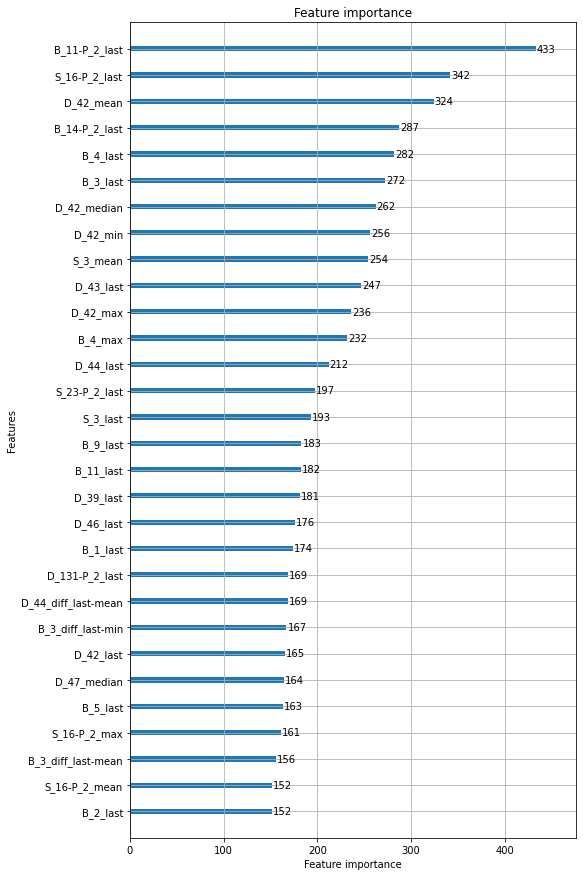

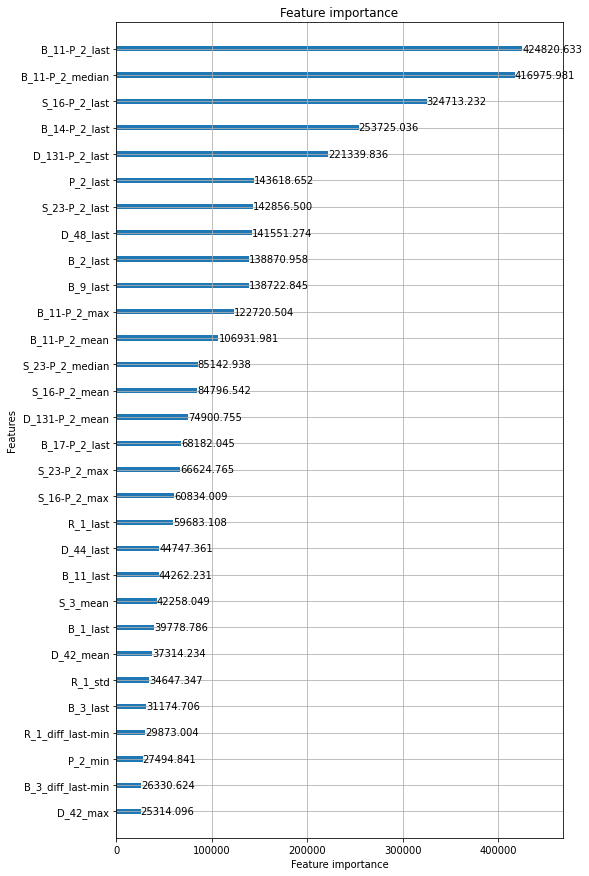

######################################## training model 2/5 ########################################


[50]	valid_0's amex_metric: 0.750267	valid_0's recall_at4: 0.600311	valid_0's norm_gini: 0.900223


[100]	valid_0's amex_metric: 0.758862	valid_0's recall_at4: 0.611967	valid_0's norm_gini: 0.905758


[150]	valid_0's amex_metric: 0.764923	valid_0's recall_at4: 0.620256	valid_0's norm_gini: 0.90959


[200]	valid_0's amex_metric: 0.771593	valid_0's recall_at4: 0.629976	valid_0's norm_gini: 0.91321


[250]	valid_0's amex_metric: 0.775474	valid_0's recall_at4: 0.635446	valid_0's norm_gini: 0.915502


[300]	valid_0's amex_metric: 0.778244	valid_0's recall_at4: 0.639443	valid_0's norm_gini: 0.917044


[350]	valid_0's amex_metric: 0.780178	valid_0's recall_at4: 0.642052	valid_0's norm_gini: 0.918305


[400]	valid_0's amex_metric: 0.781896	valid_0's recall_at4: 0.644576	valid_0's norm_gini: 0.919215


[450]	valid_0's amex_metric: 0.783184	valid_0's recall_at4: 0.64647	valid_0's norm_gini: 0.919897


[500]	valid_0's amex_metric: 0.784613	valid_0's recall_at4: 0.648826	valid_0's norm_gini: 0.920401


[550]	valid_0's amex_metric: 0.786369	valid_0's recall_at4: 0.651856	valid_0's norm_gini: 0.920883


[600]	valid_0's amex_metric: 0.787134	valid_0's recall_at4: 0.653118	valid_0's norm_gini: 0.921149


[650]	valid_0's amex_metric: 0.787916	valid_0's recall_at4: 0.654296	valid_0's norm_gini: 0.921536


[700]	valid_0's amex_metric: 0.788713	valid_0's recall_at4: 0.6556	valid_0's norm_gini: 0.921825


[750]	valid_0's amex_metric: 0.789596	valid_0's recall_at4: 0.657115	valid_0's norm_gini: 0.922077


[800]	valid_0's amex_metric: 0.789492	valid_0's recall_at4: 0.656694	valid_0's norm_gini: 0.92229


[850]	valid_0's amex_metric: 0.790197	valid_0's recall_at4: 0.657873	valid_0's norm_gini: 0.922522


[900]	valid_0's amex_metric: 0.790139	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.9227


[950]	valid_0's amex_metric: 0.790732	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.922918


[1000]	valid_0's amex_metric: 0.790847	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.923149


[1050]	valid_0's amex_metric: 0.791033	valid_0's recall_at4: 0.658714	valid_0's norm_gini: 0.923352


[1100]	valid_0's amex_metric: 0.792111	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.923572


[1150]	valid_0's amex_metric: 0.79192	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.923737


[1200]	valid_0's amex_metric: 0.792271	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.923851


[1250]	valid_0's amex_metric: 0.792292	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.923977


[1300]	valid_0's amex_metric: 0.792449	valid_0's recall_at4: 0.660818	valid_0's norm_gini: 0.924079


[1350]	valid_0's amex_metric: 0.792853	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.924131


[1400]	valid_0's amex_metric: 0.79308	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.924249


[1450]	valid_0's amex_metric: 0.792819	valid_0's recall_at4: 0.661323	valid_0's norm_gini: 0.924315


[1500]	valid_0's amex_metric: 0.793046	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.924391


[1550]	valid_0's amex_metric: 0.793173	valid_0's recall_at4: 0.66187	valid_0's norm_gini: 0.924475


[1600]	valid_0's amex_metric: 0.79368	valid_0's recall_at4: 0.662838	valid_0's norm_gini: 0.924521


[1650]	valid_0's amex_metric: 0.793514	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.92457


[1700]	valid_0's amex_metric: 0.793694	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.924592


[1750]	valid_0's amex_metric: 0.793591	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.92468


[1800]	valid_0's amex_metric: 0.794015	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.92473


[1850]	valid_0's amex_metric: 0.793731	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.924793


[1900]	valid_0's amex_metric: 0.793775	valid_0's recall_at4: 0.662754	valid_0's norm_gini: 0.924797


[1950]	valid_0's amex_metric: 0.794396	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.92486


[2000]	valid_0's amex_metric: 0.794365	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.924883


[2050]	valid_0's amex_metric: 0.794523	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924905


[2100]	valid_0's amex_metric: 0.794819	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.92495


[2150]	valid_0's amex_metric: 0.7946	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.924975


[2200]	valid_0's amex_metric: 0.79471	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.925025


[2250]	valid_0's amex_metric: 0.795056	valid_0's recall_at4: 0.665068	valid_0's norm_gini: 0.925045


[2300]	valid_0's amex_metric: 0.795072	valid_0's recall_at4: 0.665068	valid_0's norm_gini: 0.925076


[2350]	valid_0's amex_metric: 0.795167	valid_0's recall_at4: 0.665236	valid_0's norm_gini: 0.925098


[2400]	valid_0's amex_metric: 0.79548	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.925134


[2450]	valid_0's amex_metric: 0.795502	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.925179


[2500]	valid_0's amex_metric: 0.795337	valid_0's recall_at4: 0.665489	valid_0's norm_gini: 0.925186


[2550]	valid_0's amex_metric: 0.795809	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.925204


[2600]	valid_0's amex_metric: 0.795652	valid_0's recall_at4: 0.666078	valid_0's norm_gini: 0.925226


[2650]	valid_0's amex_metric: 0.795722	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.92524


[2700]	valid_0's amex_metric: 0.795619	valid_0's recall_at4: 0.665993	valid_0's norm_gini: 0.925244


[2750]	valid_0's amex_metric: 0.795732	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.925259


[2800]	valid_0's amex_metric: 0.795462	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.925268


[2850]	valid_0's amex_metric: 0.795155	valid_0's recall_at4: 0.665026	valid_0's norm_gini: 0.925284


[2900]	valid_0's amex_metric: 0.795496	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.925294


[2950]	valid_0's amex_metric: 0.795314	valid_0's recall_at4: 0.66532	valid_0's norm_gini: 0.925308


[3000]	valid_0's amex_metric: 0.795297	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.925316


[3050]	valid_0's amex_metric: 0.795113	valid_0's recall_at4: 0.664899	valid_0's norm_gini: 0.925326


[3100]	valid_0's amex_metric: 0.794994	valid_0's recall_at4: 0.664647	valid_0's norm_gini: 0.925341


[3150]	valid_0's amex_metric: 0.795572	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.925361


[3200]	valid_0's amex_metric: 0.795256	valid_0's recall_at4: 0.665152	valid_0's norm_gini: 0.92536


[3250]	valid_0's amex_metric: 0.795337	valid_0's recall_at4: 0.66532	valid_0's norm_gini: 0.925354


[3300]	valid_0's amex_metric: 0.79481	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.925351


[3350]	valid_0's amex_metric: 0.794819	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.925328


[3400]	valid_0's amex_metric: 0.795166	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.925349


[3450]	valid_0's amex_metric: 0.795192	valid_0's recall_at4: 0.665026	valid_0's norm_gini: 0.925358


[3500]	valid_0's amex_metric: 0.795149	valid_0's recall_at4: 0.664941	valid_0's norm_gini: 0.925357


[3550]	valid_0's amex_metric: 0.79486	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.925368


[3600]	valid_0's amex_metric: 0.794585	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.925365


[3650]	valid_0's amex_metric: 0.794851	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.925391


[3700]	valid_0's amex_metric: 0.794534	valid_0's recall_at4: 0.663679	valid_0's norm_gini: 0.92539


[3750]	valid_0's amex_metric: 0.794606	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.925407


[3800]	valid_0's amex_metric: 0.794691	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.925408


[3850]	valid_0's amex_metric: 0.794307	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.925397


[3900]	valid_0's amex_metric: 0.794306	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.925396


[3950]	valid_0's amex_metric: 0.794259	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.925386


[4000]	valid_0's amex_metric: 0.794481	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.925367


[4050]	valid_0's amex_metric: 0.794329	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.925357


[4100]	valid_0's amex_metric: 0.794434	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.925358


[4150]	valid_0's amex_metric: 0.794036	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.925361


[4200]	valid_0's amex_metric: 0.79443	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.925349


[4250]	valid_0's amex_metric: 0.794283	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.925349


[4300]	valid_0's amex_metric: 0.794886	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.925335


[4350]	valid_0's amex_metric: 0.794743	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.925345


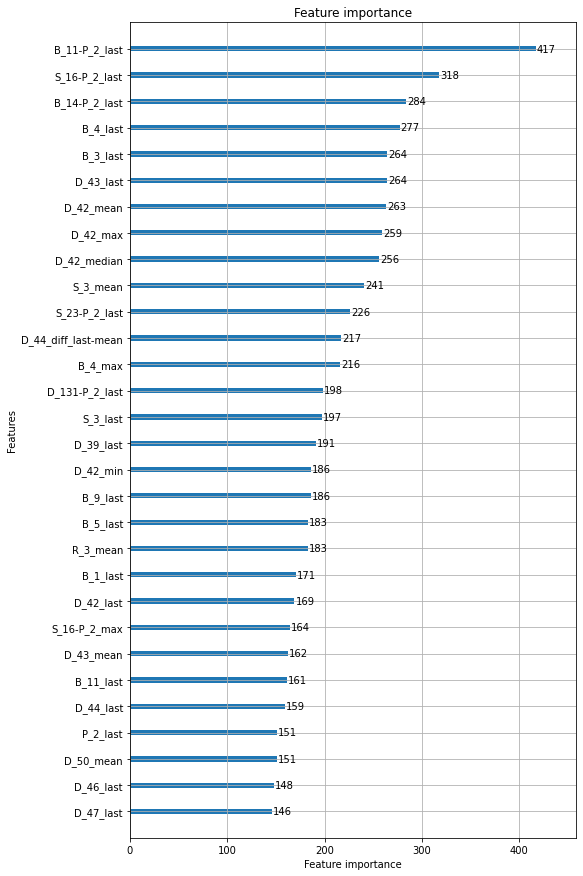

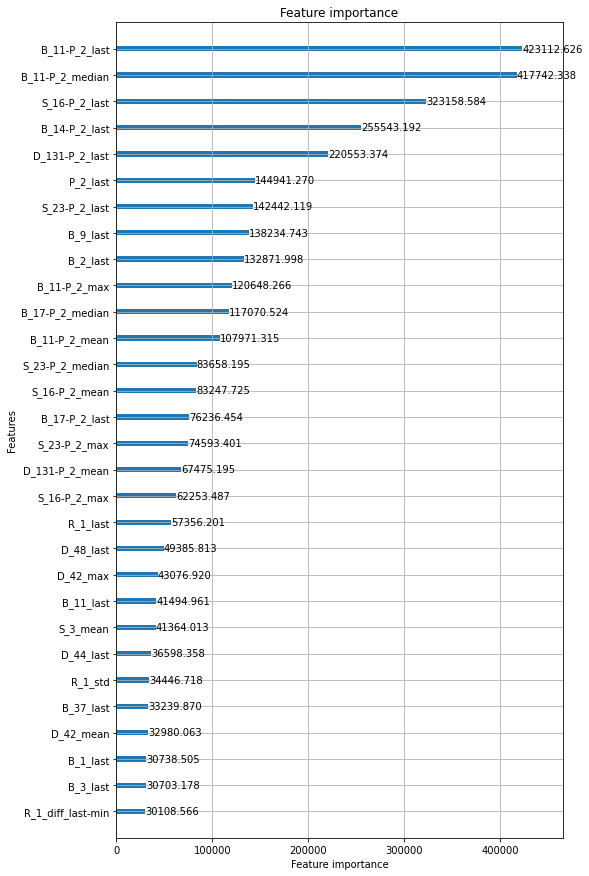

######################################## training model 3/5 ########################################


[50]	valid_0's amex_metric: 0.746673	valid_0's recall_at4: 0.594463	valid_0's norm_gini: 0.898884


[100]	valid_0's amex_metric: 0.755666	valid_0's recall_at4: 0.607128	valid_0's norm_gini: 0.904203


[150]	valid_0's amex_metric: 0.762764	valid_0's recall_at4: 0.617479	valid_0's norm_gini: 0.908049


[200]	valid_0's amex_metric: 0.769069	valid_0's recall_at4: 0.626273	valid_0's norm_gini: 0.911865


[250]	valid_0's amex_metric: 0.773454	valid_0's recall_at4: 0.632668	valid_0's norm_gini: 0.91424


[300]	valid_0's amex_metric: 0.775963	valid_0's recall_at4: 0.635993	valid_0's norm_gini: 0.915933


[350]	valid_0's amex_metric: 0.778607	valid_0's recall_at4: 0.639948	valid_0's norm_gini: 0.917267


[400]	valid_0's amex_metric: 0.780406	valid_0's recall_at4: 0.642472	valid_0's norm_gini: 0.918339


[450]	valid_0's amex_metric: 0.781823	valid_0's recall_at4: 0.644576	valid_0's norm_gini: 0.919071


[500]	valid_0's amex_metric: 0.783005	valid_0's recall_at4: 0.646344	valid_0's norm_gini: 0.919666


[550]	valid_0's amex_metric: 0.784399	valid_0's recall_at4: 0.648574	valid_0's norm_gini: 0.920224


[600]	valid_0's amex_metric: 0.784822	valid_0's recall_at4: 0.649121	valid_0's norm_gini: 0.920523


[650]	valid_0's amex_metric: 0.785792	valid_0's recall_at4: 0.65072	valid_0's norm_gini: 0.920865


[700]	valid_0's amex_metric: 0.787019	valid_0's recall_at4: 0.652865	valid_0's norm_gini: 0.921173


[750]	valid_0's amex_metric: 0.78732	valid_0's recall_at4: 0.65316	valid_0's norm_gini: 0.92148


[800]	valid_0's amex_metric: 0.787751	valid_0's recall_at4: 0.653791	valid_0's norm_gini: 0.921711


[850]	valid_0's amex_metric: 0.787516	valid_0's recall_at4: 0.653034	valid_0's norm_gini: 0.921998


[900]	valid_0's amex_metric: 0.788188	valid_0's recall_at4: 0.65417	valid_0's norm_gini: 0.922206


[950]	valid_0's amex_metric: 0.787985	valid_0's recall_at4: 0.653497	valid_0's norm_gini: 0.922473


[1000]	valid_0's amex_metric: 0.788881	valid_0's recall_at4: 0.655096	valid_0's norm_gini: 0.922666


[1050]	valid_0's amex_metric: 0.78937	valid_0's recall_at4: 0.655853	valid_0's norm_gini: 0.922887


[1100]	valid_0's amex_metric: 0.790005	valid_0's recall_at4: 0.656905	valid_0's norm_gini: 0.923105


[1150]	valid_0's amex_metric: 0.790337	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.923264


[1200]	valid_0's amex_metric: 0.790569	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.923392


[1250]	valid_0's amex_metric: 0.790867	valid_0's recall_at4: 0.658209	valid_0's norm_gini: 0.923524


[1300]	valid_0's amex_metric: 0.790279	valid_0's recall_at4: 0.656947	valid_0's norm_gini: 0.923611


[1350]	valid_0's amex_metric: 0.790414	valid_0's recall_at4: 0.657157	valid_0's norm_gini: 0.923671


[1400]	valid_0's amex_metric: 0.790973	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.92378


[1450]	valid_0's amex_metric: 0.791754	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.923868


[1500]	valid_0's amex_metric: 0.791647	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.92395


[1550]	valid_0's amex_metric: 0.791562	valid_0's recall_at4: 0.659051	valid_0's norm_gini: 0.924073


[1600]	valid_0's amex_metric: 0.792259	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.924121


[1650]	valid_0's amex_metric: 0.791948	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.924172


[1700]	valid_0's amex_metric: 0.791697	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.924217


[1750]	valid_0's amex_metric: 0.792159	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.9243


[1800]	valid_0's amex_metric: 0.791972	valid_0's recall_at4: 0.659598	valid_0's norm_gini: 0.924346


[1850]	valid_0's amex_metric: 0.792247	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.92439


[1900]	valid_0's amex_metric: 0.792284	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.924423


[1950]	valid_0's amex_metric: 0.792648	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.92452


[2000]	valid_0's amex_metric: 0.792592	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.924576


[2050]	valid_0's amex_metric: 0.792776	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.924608


[2100]	valid_0's amex_metric: 0.792738	valid_0's recall_at4: 0.660818	valid_0's norm_gini: 0.924658


[2150]	valid_0's amex_metric: 0.792727	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.924677


[2200]	valid_0's amex_metric: 0.792533	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.924711


[2250]	valid_0's amex_metric: 0.793104	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.924717


[2300]	valid_0's amex_metric: 0.793021	valid_0's recall_at4: 0.661323	valid_0's norm_gini: 0.92472


[2350]	valid_0's amex_metric: 0.793433	valid_0's recall_at4: 0.662122	valid_0's norm_gini: 0.924744


[2400]	valid_0's amex_metric: 0.793322	valid_0's recall_at4: 0.66187	valid_0's norm_gini: 0.924773


[2450]	valid_0's amex_metric: 0.792987	valid_0's recall_at4: 0.661197	valid_0's norm_gini: 0.924778


[2500]	valid_0's amex_metric: 0.793034	valid_0's recall_at4: 0.661281	valid_0's norm_gini: 0.924787


[2550]	valid_0's amex_metric: 0.793066	valid_0's recall_at4: 0.661323	valid_0's norm_gini: 0.924809


[2600]	valid_0's amex_metric: 0.793434	valid_0's recall_at4: 0.662038	valid_0's norm_gini: 0.92483


[2650]	valid_0's amex_metric: 0.7932	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.924824


[2700]	valid_0's amex_metric: 0.793055	valid_0's recall_at4: 0.661281	valid_0's norm_gini: 0.92483


[2750]	valid_0's amex_metric: 0.793202	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.924829


[2800]	valid_0's amex_metric: 0.792801	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.924826


[2850]	valid_0's amex_metric: 0.793108	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.92485


[2900]	valid_0's amex_metric: 0.793627	valid_0's recall_at4: 0.662375	valid_0's norm_gini: 0.92488


[2950]	valid_0's amex_metric: 0.793644	valid_0's recall_at4: 0.662375	valid_0's norm_gini: 0.924913


[3000]	valid_0's amex_metric: 0.794124	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924947


[3050]	valid_0's amex_metric: 0.794134	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924968


[3100]	valid_0's amex_metric: 0.793966	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.924969


[3150]	valid_0's amex_metric: 0.794118	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.924978


[3200]	valid_0's amex_metric: 0.794431	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.924973


[3250]	valid_0's amex_metric: 0.793721	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924984


[3300]	valid_0's amex_metric: 0.793893	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.924991


[3350]	valid_0's amex_metric: 0.79377	valid_0's recall_at4: 0.662543	valid_0's norm_gini: 0.924996


[3400]	valid_0's amex_metric: 0.79422	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.925013


[3450]	valid_0's amex_metric: 0.794135	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.925012


[3500]	valid_0's amex_metric: 0.79453	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.925002


[3550]	valid_0's amex_metric: 0.794227	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.925027


[3600]	valid_0's amex_metric: 0.79404	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.925031


[3650]	valid_0's amex_metric: 0.794134	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.925051


[3700]	valid_0's amex_metric: 0.794387	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.925052


[3750]	valid_0's amex_metric: 0.794225	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.925065


[3800]	valid_0's amex_metric: 0.794253	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.925122


[3850]	valid_0's amex_metric: 0.794373	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.925109


[3900]	valid_0's amex_metric: 0.794036	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.925108


[3950]	valid_0's amex_metric: 0.794534	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.925094


[4000]	valid_0's amex_metric: 0.794494	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.925098


[4050]	valid_0's amex_metric: 0.794196	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.925092


[4100]	valid_0's amex_metric: 0.79411	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.925087


[4150]	valid_0's amex_metric: 0.793768	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.925077


[4200]	valid_0's amex_metric: 0.794384	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.925046


[4250]	valid_0's amex_metric: 0.79463	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.925033


[4300]	valid_0's amex_metric: 0.794459	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.925028


[4350]	valid_0's amex_metric: 0.794793	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.925023


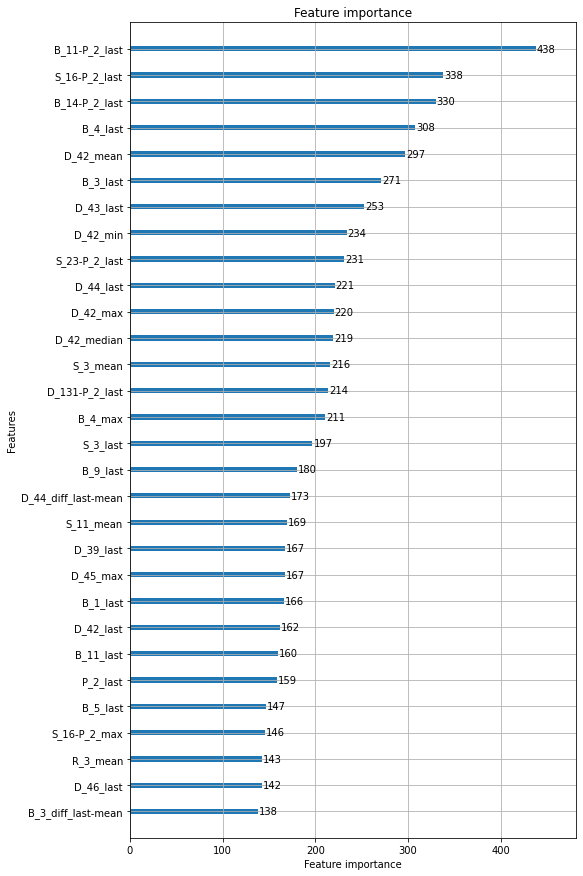

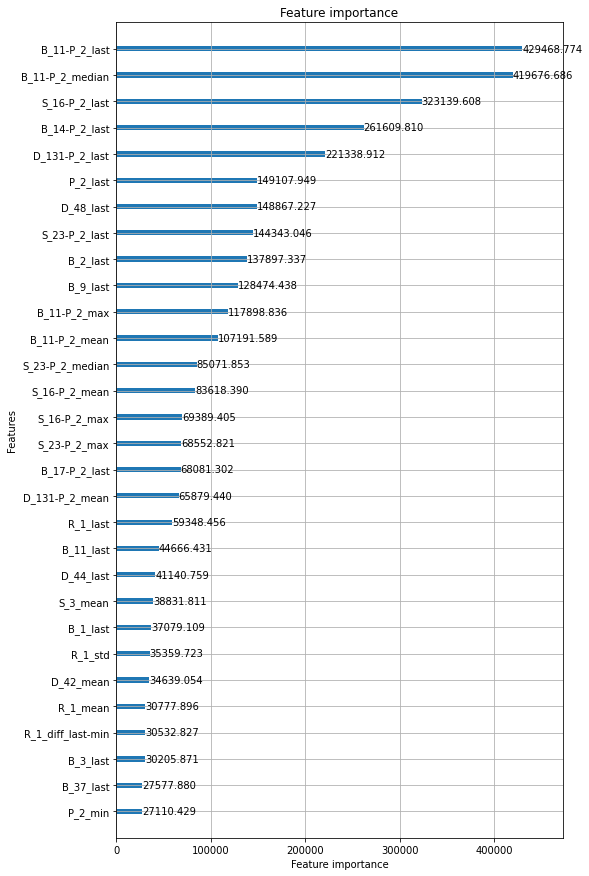

######################################## training model 4/5 ########################################


[50]	valid_0's amex_metric: 0.755251	valid_0's recall_at4: 0.608879	valid_0's norm_gini: 0.901623


[100]	valid_0's amex_metric: 0.763728	valid_0's recall_at4: 0.620787	valid_0's norm_gini: 0.906668


[150]	valid_0's amex_metric: 0.770141	valid_0's recall_at4: 0.629834	valid_0's norm_gini: 0.910448


[200]	valid_0's amex_metric: 0.775552	valid_0's recall_at4: 0.63724	valid_0's norm_gini: 0.913864


[250]	valid_0's amex_metric: 0.779897	valid_0's recall_at4: 0.643678	valid_0's norm_gini: 0.916116


[300]	valid_0's amex_metric: 0.784483	valid_0's recall_at4: 0.65121	valid_0's norm_gini: 0.917756


[350]	valid_0's amex_metric: 0.786694	valid_0's recall_at4: 0.654366	valid_0's norm_gini: 0.919023


[400]	valid_0's amex_metric: 0.789085	valid_0's recall_at4: 0.658237	valid_0's norm_gini: 0.919933


[450]	valid_0's amex_metric: 0.789188	valid_0's recall_at4: 0.657774	valid_0's norm_gini: 0.920602


[500]	valid_0's amex_metric: 0.790585	valid_0's recall_at4: 0.660004	valid_0's norm_gini: 0.921165


[550]	valid_0's amex_metric: 0.791379	valid_0's recall_at4: 0.661056	valid_0's norm_gini: 0.921702


[600]	valid_0's amex_metric: 0.792926	valid_0's recall_at4: 0.663833	valid_0's norm_gini: 0.922019


[650]	valid_0's amex_metric: 0.793606	valid_0's recall_at4: 0.664885	valid_0's norm_gini: 0.922326


[700]	valid_0's amex_metric: 0.794421	valid_0's recall_at4: 0.66619	valid_0's norm_gini: 0.922652


[750]	valid_0's amex_metric: 0.794749	valid_0's recall_at4: 0.666611	valid_0's norm_gini: 0.922887


[800]	valid_0's amex_metric: 0.795261	valid_0's recall_at4: 0.667452	valid_0's norm_gini: 0.923069


[850]	valid_0's amex_metric: 0.795852	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.923326


[900]	valid_0's amex_metric: 0.795471	valid_0's recall_at4: 0.667452	valid_0's norm_gini: 0.92349


[950]	valid_0's amex_metric: 0.796387	valid_0's recall_at4: 0.669051	valid_0's norm_gini: 0.923724


[1000]	valid_0's amex_metric: 0.796225	valid_0's recall_at4: 0.668504	valid_0's norm_gini: 0.923946


[1050]	valid_0's amex_metric: 0.796281	valid_0's recall_at4: 0.66842	valid_0's norm_gini: 0.924141


[1100]	valid_0's amex_metric: 0.79719	valid_0's recall_at4: 0.670019	valid_0's norm_gini: 0.924361


[1150]	valid_0's amex_metric: 0.797285	valid_0's recall_at4: 0.670061	valid_0's norm_gini: 0.92451


[1200]	valid_0's amex_metric: 0.797565	valid_0's recall_at4: 0.670482	valid_0's norm_gini: 0.924648


[1250]	valid_0's amex_metric: 0.797422	valid_0's recall_at4: 0.670103	valid_0's norm_gini: 0.92474


[1300]	valid_0's amex_metric: 0.798092	valid_0's recall_at4: 0.671365	valid_0's norm_gini: 0.924818


[1350]	valid_0's amex_metric: 0.798242	valid_0's recall_at4: 0.671576	valid_0's norm_gini: 0.924907


[1400]	valid_0's amex_metric: 0.79828	valid_0's recall_at4: 0.671576	valid_0's norm_gini: 0.924985


[1450]	valid_0's amex_metric: 0.798708	valid_0's recall_at4: 0.672333	valid_0's norm_gini: 0.925082


[1500]	valid_0's amex_metric: 0.798351	valid_0's recall_at4: 0.671534	valid_0's norm_gini: 0.925168


[1550]	valid_0's amex_metric: 0.798346	valid_0's recall_at4: 0.67145	valid_0's norm_gini: 0.925242


[1600]	valid_0's amex_metric: 0.798577	valid_0's recall_at4: 0.671828	valid_0's norm_gini: 0.925326


[1650]	valid_0's amex_metric: 0.798257	valid_0's recall_at4: 0.671155	valid_0's norm_gini: 0.925359


[1700]	valid_0's amex_metric: 0.798623	valid_0's recall_at4: 0.671828	valid_0's norm_gini: 0.925417


[1750]	valid_0's amex_metric: 0.798634	valid_0's recall_at4: 0.671786	valid_0's norm_gini: 0.925482


[1800]	valid_0's amex_metric: 0.799474	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.925522


[1850]	valid_0's amex_metric: 0.799086	valid_0's recall_at4: 0.672628	valid_0's norm_gini: 0.925545


[1900]	valid_0's amex_metric: 0.799084	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.925581


[1950]	valid_0's amex_metric: 0.799406	valid_0's recall_at4: 0.673175	valid_0's norm_gini: 0.925637


[2000]	valid_0's amex_metric: 0.799757	valid_0's recall_at4: 0.673848	valid_0's norm_gini: 0.925667


[2050]	valid_0's amex_metric: 0.799146	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.925706


[2100]	valid_0's amex_metric: 0.799047	valid_0's recall_at4: 0.672375	valid_0's norm_gini: 0.925718


[2150]	valid_0's amex_metric: 0.79898	valid_0's recall_at4: 0.672207	valid_0's norm_gini: 0.925754


[2200]	valid_0's amex_metric: 0.799173	valid_0's recall_at4: 0.672544	valid_0's norm_gini: 0.925802


[2250]	valid_0's amex_metric: 0.799354	valid_0's recall_at4: 0.67288	valid_0's norm_gini: 0.925828


[2300]	valid_0's amex_metric: 0.799173	valid_0's recall_at4: 0.672502	valid_0's norm_gini: 0.925845


[2350]	valid_0's amex_metric: 0.799067	valid_0's recall_at4: 0.672291	valid_0's norm_gini: 0.925843


[2400]	valid_0's amex_metric: 0.798885	valid_0's recall_at4: 0.67187	valid_0's norm_gini: 0.9259


[2450]	valid_0's amex_metric: 0.798829	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.925913


[2500]	valid_0's amex_metric: 0.799389	valid_0's recall_at4: 0.672838	valid_0's norm_gini: 0.925939


[2550]	valid_0's amex_metric: 0.799478	valid_0's recall_at4: 0.673007	valid_0's norm_gini: 0.925949


[2600]	valid_0's amex_metric: 0.799205	valid_0's recall_at4: 0.672417	valid_0's norm_gini: 0.925993


[2650]	valid_0's amex_metric: 0.799305	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.926024


[2700]	valid_0's amex_metric: 0.798904	valid_0's recall_at4: 0.671786	valid_0's norm_gini: 0.926022


[2750]	valid_0's amex_metric: 0.798906	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.926068


[2800]	valid_0's amex_metric: 0.798758	valid_0's recall_at4: 0.67145	valid_0's norm_gini: 0.926067


[2850]	valid_0's amex_metric: 0.798911	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.926077


[2900]	valid_0's amex_metric: 0.799427	valid_0's recall_at4: 0.672754	valid_0's norm_gini: 0.926101


[2950]	valid_0's amex_metric: 0.799211	valid_0's recall_at4: 0.672291	valid_0's norm_gini: 0.92613


[3000]	valid_0's amex_metric: 0.799445	valid_0's recall_at4: 0.672754	valid_0's norm_gini: 0.926136


[3050]	valid_0's amex_metric: 0.799493	valid_0's recall_at4: 0.672838	valid_0's norm_gini: 0.926147


[3100]	valid_0's amex_metric: 0.79954	valid_0's recall_at4: 0.672922	valid_0's norm_gini: 0.926158


[3150]	valid_0's amex_metric: 0.799625	valid_0's recall_at4: 0.673091	valid_0's norm_gini: 0.926158


[3200]	valid_0's amex_metric: 0.799702	valid_0's recall_at4: 0.673259	valid_0's norm_gini: 0.926146


[3250]	valid_0's amex_metric: 0.800106	valid_0's recall_at4: 0.674058	valid_0's norm_gini: 0.926153


[3300]	valid_0's amex_metric: 0.80021	valid_0's recall_at4: 0.674269	valid_0's norm_gini: 0.926151


[3350]	valid_0's amex_metric: 0.799969	valid_0's recall_at4: 0.673806	valid_0's norm_gini: 0.926132


[3400]	valid_0's amex_metric: 0.799688	valid_0's recall_at4: 0.673217	valid_0's norm_gini: 0.926159


[3450]	valid_0's amex_metric: 0.800015	valid_0's recall_at4: 0.673848	valid_0's norm_gini: 0.926182


[3500]	valid_0's amex_metric: 0.799631	valid_0's recall_at4: 0.673091	valid_0's norm_gini: 0.926171


[3550]	valid_0's amex_metric: 0.799048	valid_0's recall_at4: 0.671912	valid_0's norm_gini: 0.926184


[3600]	valid_0's amex_metric: 0.799782	valid_0's recall_at4: 0.673385	valid_0's norm_gini: 0.926179


[3650]	valid_0's amex_metric: 0.79935	valid_0's recall_at4: 0.672502	valid_0's norm_gini: 0.926198


[3700]	valid_0's amex_metric: 0.799541	valid_0's recall_at4: 0.67288	valid_0's norm_gini: 0.926201


[3750]	valid_0's amex_metric: 0.799731	valid_0's recall_at4: 0.673259	valid_0's norm_gini: 0.926203


[3800]	valid_0's amex_metric: 0.799915	valid_0's recall_at4: 0.673596	valid_0's norm_gini: 0.926234


[3850]	valid_0's amex_metric: 0.799593	valid_0's recall_at4: 0.672964	valid_0's norm_gini: 0.926222


[3900]	valid_0's amex_metric: 0.799741	valid_0's recall_at4: 0.673259	valid_0's norm_gini: 0.926224


[3950]	valid_0's amex_metric: 0.799971	valid_0's recall_at4: 0.673722	valid_0's norm_gini: 0.92622


[4000]	valid_0's amex_metric: 0.799843	valid_0's recall_at4: 0.673469	valid_0's norm_gini: 0.926217


[4050]	valid_0's amex_metric: 0.799685	valid_0's recall_at4: 0.673175	valid_0's norm_gini: 0.926196


[4100]	valid_0's amex_metric: 0.799389	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.926193


[4150]	valid_0's amex_metric: 0.799427	valid_0's recall_at4: 0.67267	valid_0's norm_gini: 0.926185


[4200]	valid_0's amex_metric: 0.799994	valid_0's recall_at4: 0.673806	valid_0's norm_gini: 0.926181


[4250]	valid_0's amex_metric: 0.799659	valid_0's recall_at4: 0.673133	valid_0's norm_gini: 0.926184


[4300]	valid_0's amex_metric: 0.800264	valid_0's recall_at4: 0.674353	valid_0's norm_gini: 0.926174


[4350]	valid_0's amex_metric: 0.800227	valid_0's recall_at4: 0.674269	valid_0's norm_gini: 0.926184


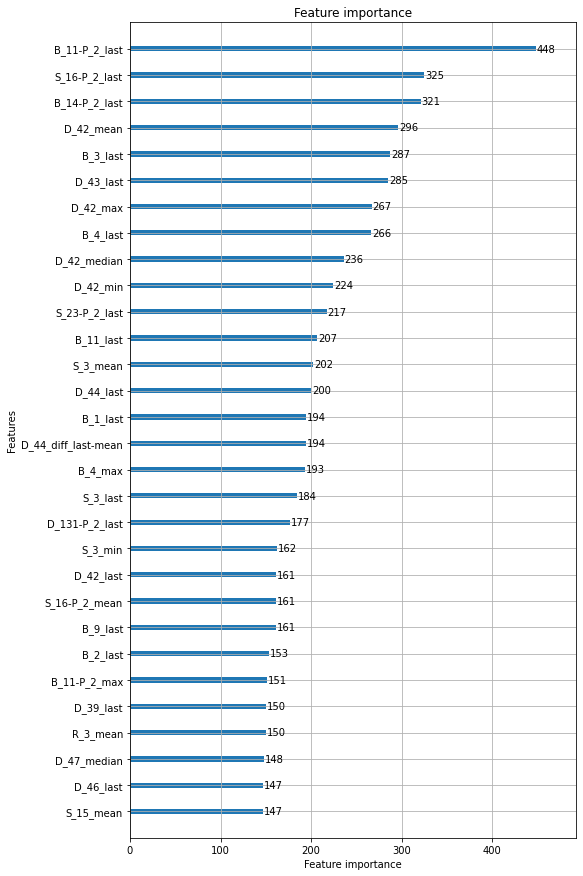

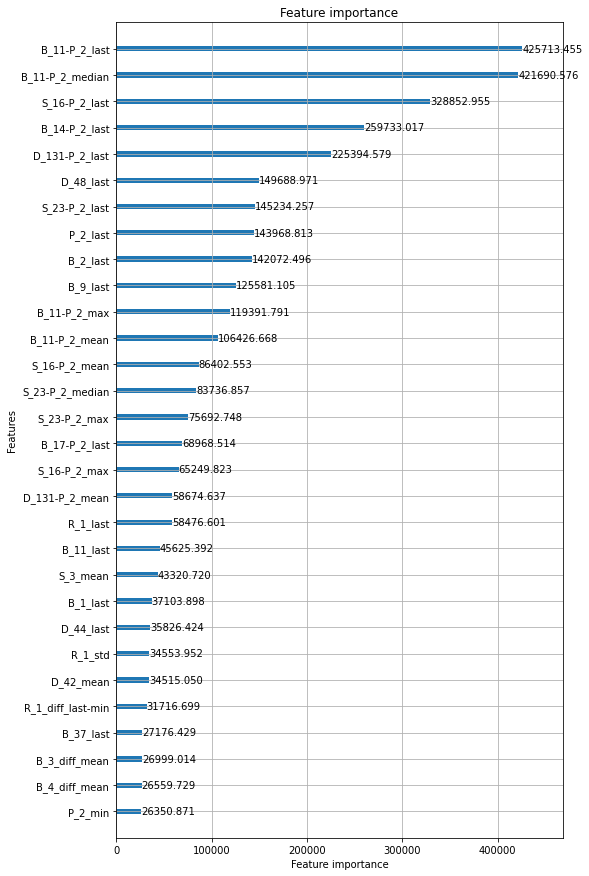

######################################## training model 5/5 ########################################


[50]	valid_0's amex_metric: 0.753267	valid_0's recall_at4: 0.604797	valid_0's norm_gini: 0.901737


[100]	valid_0's amex_metric: 0.762631	valid_0's recall_at4: 0.618178	valid_0's norm_gini: 0.907083


[150]	valid_0's amex_metric: 0.768682	valid_0's recall_at4: 0.626678	valid_0's norm_gini: 0.910686


[200]	valid_0's amex_metric: 0.77526	valid_0's recall_at4: 0.63623	valid_0's norm_gini: 0.91429


[250]	valid_0's amex_metric: 0.778773	valid_0's recall_at4: 0.641111	valid_0's norm_gini: 0.916436


[300]	valid_0's amex_metric: 0.781732	valid_0's recall_at4: 0.645487	valid_0's norm_gini: 0.917978


[350]	valid_0's amex_metric: 0.784806	valid_0's recall_at4: 0.65041	valid_0's norm_gini: 0.919202


[400]	valid_0's amex_metric: 0.786375	valid_0's recall_at4: 0.652598	valid_0's norm_gini: 0.920152


[450]	valid_0's amex_metric: 0.787993	valid_0's recall_at4: 0.655165	valid_0's norm_gini: 0.920821


[500]	valid_0's amex_metric: 0.788676	valid_0's recall_at4: 0.656007	valid_0's norm_gini: 0.921345


[550]	valid_0's amex_metric: 0.790366	valid_0's recall_at4: 0.658868	valid_0's norm_gini: 0.921865


[600]	valid_0's amex_metric: 0.790653	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.922186


[650]	valid_0's amex_metric: 0.791121	valid_0's recall_at4: 0.65971	valid_0's norm_gini: 0.922533


[700]	valid_0's amex_metric: 0.791996	valid_0's recall_at4: 0.661098	valid_0's norm_gini: 0.922895


[750]	valid_0's amex_metric: 0.792748	valid_0's recall_at4: 0.662361	valid_0's norm_gini: 0.923135


[800]	valid_0's amex_metric: 0.793613	valid_0's recall_at4: 0.663875	valid_0's norm_gini: 0.923351


[850]	valid_0's amex_metric: 0.793291	valid_0's recall_at4: 0.66295	valid_0's norm_gini: 0.923633


[900]	valid_0's amex_metric: 0.793665	valid_0's recall_at4: 0.663539	valid_0's norm_gini: 0.923792


[950]	valid_0's amex_metric: 0.794347	valid_0's recall_at4: 0.664675	valid_0's norm_gini: 0.924018


[1000]	valid_0's amex_metric: 0.794874	valid_0's recall_at4: 0.665516	valid_0's norm_gini: 0.924232


[1050]	valid_0's amex_metric: 0.794538	valid_0's recall_at4: 0.664633	valid_0's norm_gini: 0.924444


[1100]	valid_0's amex_metric: 0.795791	valid_0's recall_at4: 0.666905	valid_0's norm_gini: 0.924677


[1150]	valid_0's amex_metric: 0.796702	valid_0's recall_at4: 0.668588	valid_0's norm_gini: 0.924816


[1200]	valid_0's amex_metric: 0.796183	valid_0's recall_at4: 0.66741	valid_0's norm_gini: 0.924955


[1250]	valid_0's amex_metric: 0.796945	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.925049


[1300]	valid_0's amex_metric: 0.796836	valid_0's recall_at4: 0.668546	valid_0's norm_gini: 0.925125


[1350]	valid_0's amex_metric: 0.797209	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925198


[1400]	valid_0's amex_metric: 0.797217	valid_0's recall_at4: 0.669177	valid_0's norm_gini: 0.925257


[1450]	valid_0's amex_metric: 0.797284	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925348


[1500]	valid_0's amex_metric: 0.79746	valid_0's recall_at4: 0.669472	valid_0's norm_gini: 0.925447


[1550]	valid_0's amex_metric: 0.796948	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.925518


[1600]	valid_0's amex_metric: 0.797311	valid_0's recall_at4: 0.669051	valid_0's norm_gini: 0.925571


[1650]	valid_0's amex_metric: 0.797319	valid_0's recall_at4: 0.669009	valid_0's norm_gini: 0.925628


[1700]	valid_0's amex_metric: 0.797257	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.925674


[1750]	valid_0's amex_metric: 0.797412	valid_0's recall_at4: 0.669093	valid_0's norm_gini: 0.92573


[1800]	valid_0's amex_metric: 0.797494	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925769


[1850]	valid_0's amex_metric: 0.797421	valid_0's recall_at4: 0.669009	valid_0's norm_gini: 0.925834


[1900]	valid_0's amex_metric: 0.79751	valid_0's recall_at4: 0.669135	valid_0's norm_gini: 0.925884


[1950]	valid_0's amex_metric: 0.797418	valid_0's recall_at4: 0.668883	valid_0's norm_gini: 0.925953


[2000]	valid_0's amex_metric: 0.79733	valid_0's recall_at4: 0.668715	valid_0's norm_gini: 0.925945


[2050]	valid_0's amex_metric: 0.79799	valid_0's recall_at4: 0.669977	valid_0's norm_gini: 0.926003


[2100]	valid_0's amex_metric: 0.798171	valid_0's recall_at4: 0.670271	valid_0's norm_gini: 0.92607


[2150]	valid_0's amex_metric: 0.797994	valid_0's recall_at4: 0.669893	valid_0's norm_gini: 0.926096


[2200]	valid_0's amex_metric: 0.798371	valid_0's recall_at4: 0.670608	valid_0's norm_gini: 0.926134


[2250]	valid_0's amex_metric: 0.798624	valid_0's recall_at4: 0.671113	valid_0's norm_gini: 0.926134


[2300]	valid_0's amex_metric: 0.798086	valid_0's recall_at4: 0.670019	valid_0's norm_gini: 0.926154


[2350]	valid_0's amex_metric: 0.798074	valid_0's recall_at4: 0.669977	valid_0's norm_gini: 0.926172


[2400]	valid_0's amex_metric: 0.798146	valid_0's recall_at4: 0.670061	valid_0's norm_gini: 0.926231


[2450]	valid_0's amex_metric: 0.798175	valid_0's recall_at4: 0.670103	valid_0's norm_gini: 0.926247


[2500]	valid_0's amex_metric: 0.797914	valid_0's recall_at4: 0.669556	valid_0's norm_gini: 0.926272


[2550]	valid_0's amex_metric: 0.798178	valid_0's recall_at4: 0.670061	valid_0's norm_gini: 0.926295


[2600]	valid_0's amex_metric: 0.798042	valid_0's recall_at4: 0.669766	valid_0's norm_gini: 0.926317


[2650]	valid_0's amex_metric: 0.798201	valid_0's recall_at4: 0.670061	valid_0's norm_gini: 0.92634


[2700]	valid_0's amex_metric: 0.798206	valid_0's recall_at4: 0.670061	valid_0's norm_gini: 0.926351


[2750]	valid_0's amex_metric: 0.798319	valid_0's recall_at4: 0.670271	valid_0's norm_gini: 0.926367


[2800]	valid_0's amex_metric: 0.798414	valid_0's recall_at4: 0.67044	valid_0's norm_gini: 0.926388


[2850]	valid_0's amex_metric: 0.798708	valid_0's recall_at4: 0.670987	valid_0's norm_gini: 0.926428


[2900]	valid_0's amex_metric: 0.798523	valid_0's recall_at4: 0.670608	valid_0's norm_gini: 0.926437


[2950]	valid_0's amex_metric: 0.798141	valid_0's recall_at4: 0.669809	valid_0's norm_gini: 0.926474


[3000]	valid_0's amex_metric: 0.798001	valid_0's recall_at4: 0.669514	valid_0's norm_gini: 0.926488


[3050]	valid_0's amex_metric: 0.798221	valid_0's recall_at4: 0.669935	valid_0's norm_gini: 0.926507


[3100]	valid_0's amex_metric: 0.798131	valid_0's recall_at4: 0.669766	valid_0's norm_gini: 0.926495


[3150]	valid_0's amex_metric: 0.797973	valid_0's recall_at4: 0.669472	valid_0's norm_gini: 0.926474


[3200]	valid_0's amex_metric: 0.798315	valid_0's recall_at4: 0.670145	valid_0's norm_gini: 0.926485


[3250]	valid_0's amex_metric: 0.798501	valid_0's recall_at4: 0.670524	valid_0's norm_gini: 0.926478


[3300]	valid_0's amex_metric: 0.798613	valid_0's recall_at4: 0.670734	valid_0's norm_gini: 0.926493


[3350]	valid_0's amex_metric: 0.798627	valid_0's recall_at4: 0.670776	valid_0's norm_gini: 0.926478


[3400]	valid_0's amex_metric: 0.798501	valid_0's recall_at4: 0.670524	valid_0's norm_gini: 0.926477


[3450]	valid_0's amex_metric: 0.798147	valid_0's recall_at4: 0.669809	valid_0's norm_gini: 0.926485


[3500]	valid_0's amex_metric: 0.798578	valid_0's recall_at4: 0.67065	valid_0's norm_gini: 0.926506


[3550]	valid_0's amex_metric: 0.798712	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.92652


[3600]	valid_0's amex_metric: 0.798718	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.926534


[3650]	valid_0's amex_metric: 0.798827	valid_0's recall_at4: 0.671113	valid_0's norm_gini: 0.926542


[3700]	valid_0's amex_metric: 0.798662	valid_0's recall_at4: 0.670776	valid_0's norm_gini: 0.926548


[3750]	valid_0's amex_metric: 0.798416	valid_0's recall_at4: 0.670271	valid_0's norm_gini: 0.92656


[3800]	valid_0's amex_metric: 0.798588	valid_0's recall_at4: 0.670608	valid_0's norm_gini: 0.926567


[3850]	valid_0's amex_metric: 0.798553	valid_0's recall_at4: 0.670524	valid_0's norm_gini: 0.926582


[3900]	valid_0's amex_metric: 0.798829	valid_0's recall_at4: 0.671071	valid_0's norm_gini: 0.926586


[3950]	valid_0's amex_metric: 0.798833	valid_0's recall_at4: 0.671071	valid_0's norm_gini: 0.926594


[4000]	valid_0's amex_metric: 0.79917	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.926595


[4050]	valid_0's amex_metric: 0.799149	valid_0's recall_at4: 0.671702	valid_0's norm_gini: 0.926597


[4100]	valid_0's amex_metric: 0.799188	valid_0's recall_at4: 0.671786	valid_0's norm_gini: 0.926589


[4150]	valid_0's amex_metric: 0.798784	valid_0's recall_at4: 0.670987	valid_0's norm_gini: 0.926581


[4200]	valid_0's amex_metric: 0.798879	valid_0's recall_at4: 0.671155	valid_0's norm_gini: 0.926603


[4250]	valid_0's amex_metric: 0.798967	valid_0's recall_at4: 0.671323	valid_0's norm_gini: 0.92661


[4300]	valid_0's amex_metric: 0.799599	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.926613


[4350]	valid_0's amex_metric: 0.799513	valid_0's recall_at4: 0.672417	valid_0's norm_gini: 0.926608


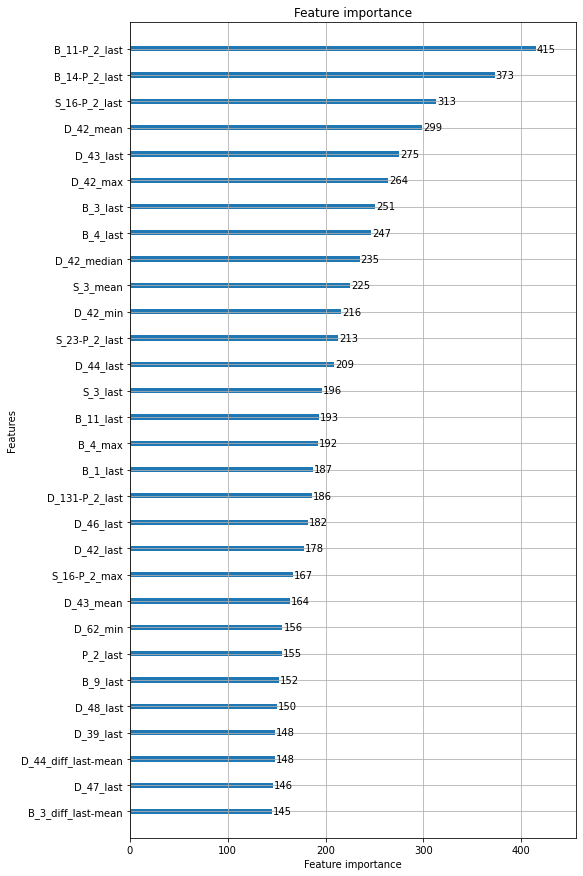

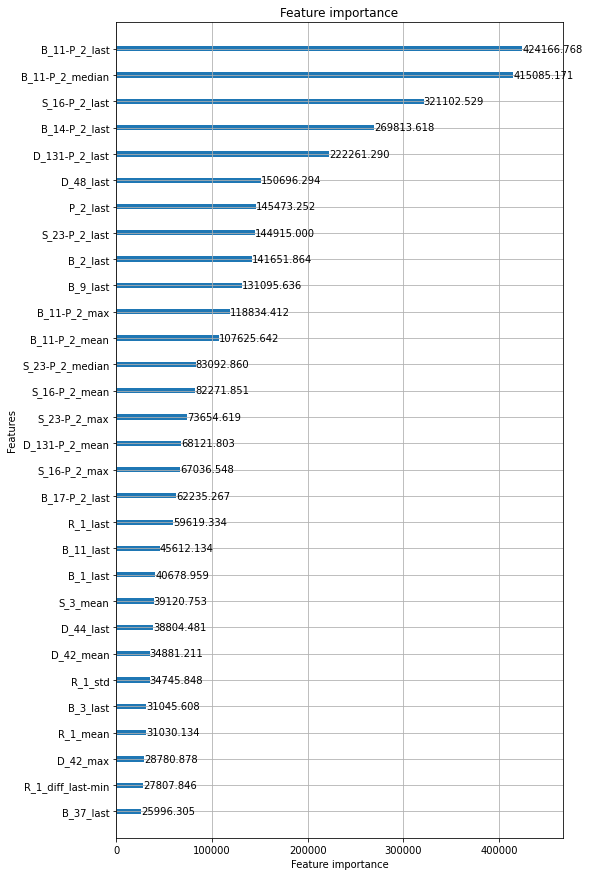

Training time: 47.90684771537781 min.
OOF recall_at4: 0.670650015147945
OOF normalized_gini: 0.9259021648044092
OOF competition metric: 0.7982760899761772


############################### repeated cross-validation step: 3/3 ################################


######################################## training model 1/5 ########################################


[50]	valid_0's amex_metric: 0.750674	valid_0's recall_at4: 0.601868	valid_0's norm_gini: 0.899479


[100]	valid_0's amex_metric: 0.75915	valid_0's recall_at4: 0.613397	valid_0's norm_gini: 0.904902


[150]	valid_0's amex_metric: 0.764276	valid_0's recall_at4: 0.619877	valid_0's norm_gini: 0.908675


[200]	valid_0's amex_metric: 0.769688	valid_0's recall_at4: 0.62703	valid_0's norm_gini: 0.912346


[250]	valid_0's amex_metric: 0.774713	valid_0's recall_at4: 0.634772	valid_0's norm_gini: 0.914653


[300]	valid_0's amex_metric: 0.778412	valid_0's recall_at4: 0.640537	valid_0's norm_gini: 0.916287


[350]	valid_0's amex_metric: 0.781565	valid_0's recall_at4: 0.645586	valid_0's norm_gini: 0.917543


[400]	valid_0's amex_metric: 0.784175	valid_0's recall_at4: 0.649836	valid_0's norm_gini: 0.918514


[450]	valid_0's amex_metric: 0.785613	valid_0's recall_at4: 0.652024	valid_0's norm_gini: 0.919202


[500]	valid_0's amex_metric: 0.786625	valid_0's recall_at4: 0.653539	valid_0's norm_gini: 0.919712


[550]	valid_0's amex_metric: 0.787017	valid_0's recall_at4: 0.653875	valid_0's norm_gini: 0.920159


[600]	valid_0's amex_metric: 0.787712	valid_0's recall_at4: 0.654969	valid_0's norm_gini: 0.920455


[650]	valid_0's amex_metric: 0.788465	valid_0's recall_at4: 0.65619	valid_0's norm_gini: 0.92074


[700]	valid_0's amex_metric: 0.789081	valid_0's recall_at4: 0.657157	valid_0's norm_gini: 0.921004


[750]	valid_0's amex_metric: 0.789504	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.921261


[800]	valid_0's amex_metric: 0.789913	valid_0's recall_at4: 0.658378	valid_0's norm_gini: 0.921449


[850]	valid_0's amex_metric: 0.790268	valid_0's recall_at4: 0.65884	valid_0's norm_gini: 0.921695


[900]	valid_0's amex_metric: 0.790483	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.921873


[950]	valid_0's amex_metric: 0.79138	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.922068


[1000]	valid_0's amex_metric: 0.791441	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.922274


[1050]	valid_0's amex_metric: 0.792385	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.92248


[1100]	valid_0's amex_metric: 0.792391	valid_0's recall_at4: 0.66208	valid_0's norm_gini: 0.922702


[1150]	valid_0's amex_metric: 0.792856	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.922833


[1200]	valid_0's amex_metric: 0.792754	valid_0's recall_at4: 0.662543	valid_0's norm_gini: 0.922966


[1250]	valid_0's amex_metric: 0.793022	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.92308


[1300]	valid_0's amex_metric: 0.793113	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.923135


[1350]	valid_0's amex_metric: 0.793485	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.923207


[1400]	valid_0's amex_metric: 0.793411	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.923311


[1450]	valid_0's amex_metric: 0.793625	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.923403


[1500]	valid_0's amex_metric: 0.793297	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.923462


[1550]	valid_0's amex_metric: 0.793061	valid_0's recall_at4: 0.662585	valid_0's norm_gini: 0.923538


[1600]	valid_0's amex_metric: 0.793172	valid_0's recall_at4: 0.662754	valid_0's norm_gini: 0.923591


[1650]	valid_0's amex_metric: 0.793418	valid_0's recall_at4: 0.663174	valid_0's norm_gini: 0.923663


[1700]	valid_0's amex_metric: 0.793863	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.92371


[1750]	valid_0's amex_metric: 0.794389	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.923794


[1800]	valid_0's amex_metric: 0.794417	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.923851


[1850]	valid_0's amex_metric: 0.794458	valid_0's recall_at4: 0.665026	valid_0's norm_gini: 0.923891


[1900]	valid_0's amex_metric: 0.794822	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.923945


[1950]	valid_0's amex_metric: 0.794014	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.92397


[2000]	valid_0's amex_metric: 0.794623	valid_0's recall_at4: 0.665236	valid_0's norm_gini: 0.924009


[2050]	valid_0's amex_metric: 0.794322	valid_0's recall_at4: 0.664605	valid_0's norm_gini: 0.924039


[2100]	valid_0's amex_metric: 0.794121	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.924057


[2150]	valid_0's amex_metric: 0.794451	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.924086


[2200]	valid_0's amex_metric: 0.794226	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.924142


[2250]	valid_0's amex_metric: 0.794991	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924156


[2300]	valid_0's amex_metric: 0.794202	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.924178


[2350]	valid_0's amex_metric: 0.794755	valid_0's recall_at4: 0.66532	valid_0's norm_gini: 0.92419


[2400]	valid_0's amex_metric: 0.794927	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.924198


[2450]	valid_0's amex_metric: 0.794645	valid_0's recall_at4: 0.665068	valid_0's norm_gini: 0.924222


[2500]	valid_0's amex_metric: 0.795032	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924239


[2550]	valid_0's amex_metric: 0.795339	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.924264


[2600]	valid_0's amex_metric: 0.795474	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924281


[2650]	valid_0's amex_metric: 0.795761	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.924307


[2700]	valid_0's amex_metric: 0.795844	valid_0's recall_at4: 0.667382	valid_0's norm_gini: 0.924306


[2750]	valid_0's amex_metric: 0.795513	valid_0's recall_at4: 0.666709	valid_0's norm_gini: 0.924317


[2800]	valid_0's amex_metric: 0.795604	valid_0's recall_at4: 0.666877	valid_0's norm_gini: 0.924331


[2850]	valid_0's amex_metric: 0.795536	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.924322


[2900]	valid_0's amex_metric: 0.795454	valid_0's recall_at4: 0.666583	valid_0's norm_gini: 0.924326


[2950]	valid_0's amex_metric: 0.795607	valid_0's recall_at4: 0.666877	valid_0's norm_gini: 0.924337


[3000]	valid_0's amex_metric: 0.795393	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.924371


[3050]	valid_0's amex_metric: 0.795389	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.924364


[3100]	valid_0's amex_metric: 0.795151	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.924351


[3150]	valid_0's amex_metric: 0.795461	valid_0's recall_at4: 0.666583	valid_0's norm_gini: 0.92434


[3200]	valid_0's amex_metric: 0.795685	valid_0's recall_at4: 0.667003	valid_0's norm_gini: 0.924366


[3250]	valid_0's amex_metric: 0.796065	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.92437


[3300]	valid_0's amex_metric: 0.795487	valid_0's recall_at4: 0.666625	valid_0's norm_gini: 0.924349


[3350]	valid_0's amex_metric: 0.795933	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.924316


[3400]	valid_0's amex_metric: 0.795584	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.924333


[3450]	valid_0's amex_metric: 0.795925	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924342


[3500]	valid_0's amex_metric: 0.79605	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.924339


[3550]	valid_0's amex_metric: 0.796157	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.924343


[3600]	valid_0's amex_metric: 0.795733	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.924336


[3650]	valid_0's amex_metric: 0.795952	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.924354


[3700]	valid_0's amex_metric: 0.796131	valid_0's recall_at4: 0.667887	valid_0's norm_gini: 0.924376


[3750]	valid_0's amex_metric: 0.795562	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.924374


[3800]	valid_0's amex_metric: 0.795713	valid_0's recall_at4: 0.667045	valid_0's norm_gini: 0.92438


[3850]	valid_0's amex_metric: 0.795692	valid_0's recall_at4: 0.667003	valid_0's norm_gini: 0.92438


[3900]	valid_0's amex_metric: 0.796177	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.924383


[3950]	valid_0's amex_metric: 0.795947	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924387


[4000]	valid_0's amex_metric: 0.795898	valid_0's recall_at4: 0.667424	valid_0's norm_gini: 0.924371


[4050]	valid_0's amex_metric: 0.795921	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.924376


[4100]	valid_0's amex_metric: 0.796019	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.924361


[4150]	valid_0's amex_metric: 0.795515	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924363


[4200]	valid_0's amex_metric: 0.795514	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924361


[4250]	valid_0's amex_metric: 0.795702	valid_0's recall_at4: 0.667045	valid_0's norm_gini: 0.924359


[4300]	valid_0's amex_metric: 0.795564	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.924377


[4350]	valid_0's amex_metric: 0.79554	valid_0's recall_at4: 0.666709	valid_0's norm_gini: 0.92437


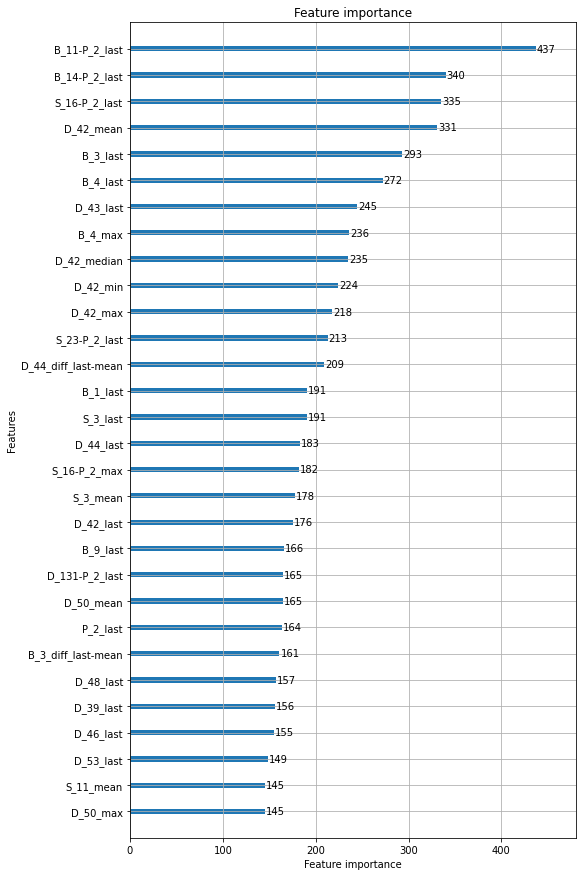

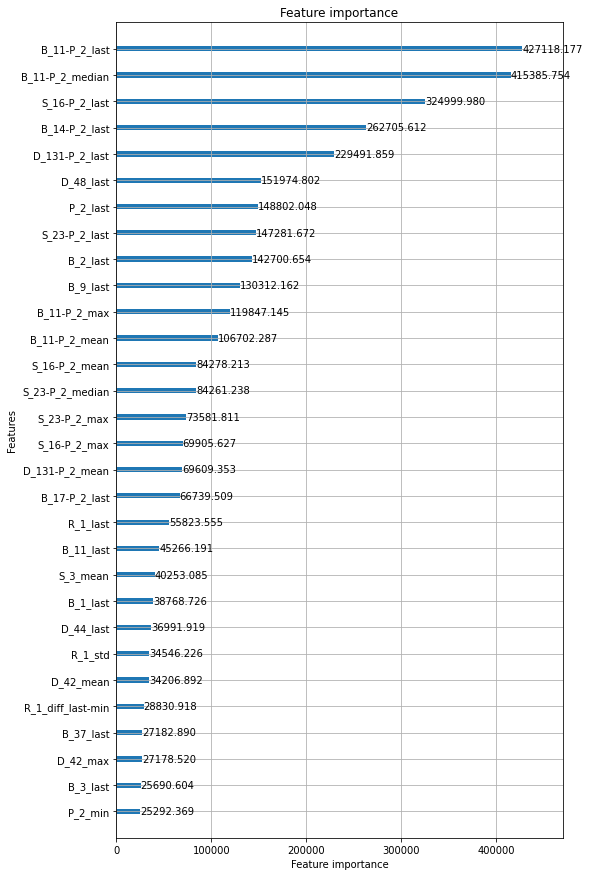

######################################## training model 2/5 ########################################


[50]	valid_0's amex_metric: 0.749998	valid_0's recall_at4: 0.599007	valid_0's norm_gini: 0.900989


[100]	valid_0's amex_metric: 0.759123	valid_0's recall_at4: 0.611967	valid_0's norm_gini: 0.90628


[150]	valid_0's amex_metric: 0.764332	valid_0's recall_at4: 0.618867	valid_0's norm_gini: 0.909797


[200]	valid_0's amex_metric: 0.770155	valid_0's recall_at4: 0.627114	valid_0's norm_gini: 0.913196


[250]	valid_0's amex_metric: 0.773374	valid_0's recall_at4: 0.631322	valid_0's norm_gini: 0.915425


[300]	valid_0's amex_metric: 0.776709	valid_0's recall_at4: 0.636287	valid_0's norm_gini: 0.917131


[350]	valid_0's amex_metric: 0.779373	valid_0's recall_at4: 0.640369	valid_0's norm_gini: 0.918378


[400]	valid_0's amex_metric: 0.780819	valid_0's recall_at4: 0.642262	valid_0's norm_gini: 0.919376


[450]	valid_0's amex_metric: 0.782382	valid_0's recall_at4: 0.64466	valid_0's norm_gini: 0.920104


[500]	valid_0's amex_metric: 0.784088	valid_0's recall_at4: 0.647522	valid_0's norm_gini: 0.920655


[550]	valid_0's amex_metric: 0.78544	valid_0's recall_at4: 0.64971	valid_0's norm_gini: 0.921171


[600]	valid_0's amex_metric: 0.785608	valid_0's recall_at4: 0.64971	valid_0's norm_gini: 0.921507


[650]	valid_0's amex_metric: 0.786265	valid_0's recall_at4: 0.650677	valid_0's norm_gini: 0.921852


[700]	valid_0's amex_metric: 0.787678	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.922154


[750]	valid_0's amex_metric: 0.788152	valid_0's recall_at4: 0.653917	valid_0's norm_gini: 0.922387


[800]	valid_0's amex_metric: 0.787974	valid_0's recall_at4: 0.65337	valid_0's norm_gini: 0.922577


[850]	valid_0's amex_metric: 0.788358	valid_0's recall_at4: 0.653875	valid_0's norm_gini: 0.92284


[900]	valid_0's amex_metric: 0.788704	valid_0's recall_at4: 0.654338	valid_0's norm_gini: 0.923069


[950]	valid_0's amex_metric: 0.788962	valid_0's recall_at4: 0.654633	valid_0's norm_gini: 0.923291


[1000]	valid_0's amex_metric: 0.789618	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.923509


[1050]	valid_0's amex_metric: 0.790645	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.923711


[1100]	valid_0's amex_metric: 0.790877	valid_0's recall_at4: 0.657831	valid_0's norm_gini: 0.923924


[1150]	valid_0's amex_metric: 0.791242	valid_0's recall_at4: 0.65842	valid_0's norm_gini: 0.924063


[1200]	valid_0's amex_metric: 0.791585	valid_0's recall_at4: 0.658967	valid_0's norm_gini: 0.924203


[1250]	valid_0's amex_metric: 0.792459	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.924353


[1300]	valid_0's amex_metric: 0.792305	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.924423


[1350]	valid_0's amex_metric: 0.79237	valid_0's recall_at4: 0.660229	valid_0's norm_gini: 0.924511


[1400]	valid_0's amex_metric: 0.793011	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.924616


[1450]	valid_0's amex_metric: 0.79252	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.924684


[1500]	valid_0's amex_metric: 0.792768	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.924802


[1550]	valid_0's amex_metric: 0.792884	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.924865


[1600]	valid_0's amex_metric: 0.793249	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.924923


[1650]	valid_0's amex_metric: 0.793661	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.925031


[1700]	valid_0's amex_metric: 0.793236	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.925064


[1750]	valid_0's amex_metric: 0.793356	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.925136


[1800]	valid_0's amex_metric: 0.793129	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.925187


[1850]	valid_0's amex_metric: 0.7935	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.925257


[1900]	valid_0's amex_metric: 0.793538	valid_0's recall_at4: 0.661786	valid_0's norm_gini: 0.925291


[1950]	valid_0's amex_metric: 0.793611	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.92531


[2000]	valid_0's amex_metric: 0.793979	valid_0's recall_at4: 0.662585	valid_0's norm_gini: 0.925374


[2050]	valid_0's amex_metric: 0.793447	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.925404


[2100]	valid_0's amex_metric: 0.79336	valid_0's recall_at4: 0.661281	valid_0's norm_gini: 0.92544


[2150]	valid_0's amex_metric: 0.793477	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.925504


[2200]	valid_0's amex_metric: 0.793679	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.92553


[2250]	valid_0's amex_metric: 0.794192	valid_0's recall_at4: 0.662838	valid_0's norm_gini: 0.925546


[2300]	valid_0's amex_metric: 0.793826	valid_0's recall_at4: 0.66208	valid_0's norm_gini: 0.925572


[2350]	valid_0's amex_metric: 0.794086	valid_0's recall_at4: 0.662585	valid_0's norm_gini: 0.925586


[2400]	valid_0's amex_metric: 0.794048	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.925594


[2450]	valid_0's amex_metric: 0.794016	valid_0's recall_at4: 0.662417	valid_0's norm_gini: 0.925616


[2500]	valid_0's amex_metric: 0.793972	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.925611


[2550]	valid_0's amex_metric: 0.79358	valid_0's recall_at4: 0.661533	valid_0's norm_gini: 0.925626


[2600]	valid_0's amex_metric: 0.793659	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.925659


[2650]	valid_0's amex_metric: 0.794026	valid_0's recall_at4: 0.662375	valid_0's norm_gini: 0.925677


[2700]	valid_0's amex_metric: 0.794373	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.925698


[2750]	valid_0's amex_metric: 0.794071	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.925684


[2800]	valid_0's amex_metric: 0.794494	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.925687


[2850]	valid_0's amex_metric: 0.794638	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.925723


[2900]	valid_0's amex_metric: 0.794815	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.925741


[2950]	valid_0's amex_metric: 0.79494	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.925739


[3000]	valid_0's amex_metric: 0.79494	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.925738


[3050]	valid_0's amex_metric: 0.794734	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.925747


[3100]	valid_0's amex_metric: 0.794656	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.925758


[3150]	valid_0's amex_metric: 0.795225	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.925761


[3200]	valid_0's amex_metric: 0.795465	valid_0's recall_at4: 0.665152	valid_0's norm_gini: 0.925779


[3250]	valid_0's amex_metric: 0.795782	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.925781


[3300]	valid_0's amex_metric: 0.795002	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.925777


[3350]	valid_0's amex_metric: 0.795053	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.925796


[3400]	valid_0's amex_metric: 0.79539	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.925796


[3450]	valid_0's amex_metric: 0.795145	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.925811


[3500]	valid_0's amex_metric: 0.795067	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.925825


[3550]	valid_0's amex_metric: 0.795106	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.925818


[3600]	valid_0's amex_metric: 0.795108	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.925821


[3650]	valid_0's amex_metric: 0.794124	valid_0's recall_at4: 0.662417	valid_0's norm_gini: 0.925831


[3700]	valid_0's amex_metric: 0.794604	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.925823


[3750]	valid_0's amex_metric: 0.794318	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.92584


[3800]	valid_0's amex_metric: 0.7945	valid_0's recall_at4: 0.663174	valid_0's norm_gini: 0.925826


[3850]	valid_0's amex_metric: 0.794664	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.925817


[3900]	valid_0's amex_metric: 0.794125	valid_0's recall_at4: 0.662417	valid_0's norm_gini: 0.925834


[3950]	valid_0's amex_metric: 0.794305	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.925814


[4000]	valid_0's amex_metric: 0.794284	valid_0's recall_at4: 0.662754	valid_0's norm_gini: 0.925815


[4050]	valid_0's amex_metric: 0.794033	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.925818


[4100]	valid_0's amex_metric: 0.794127	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.925794


[4150]	valid_0's amex_metric: 0.794071	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.92581


[4200]	valid_0's amex_metric: 0.793898	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.9258


[4250]	valid_0's amex_metric: 0.793695	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.925773


[4300]	valid_0's amex_metric: 0.793749	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.925797


[4350]	valid_0's amex_metric: 0.793938	valid_0's recall_at4: 0.66208	valid_0's norm_gini: 0.925795


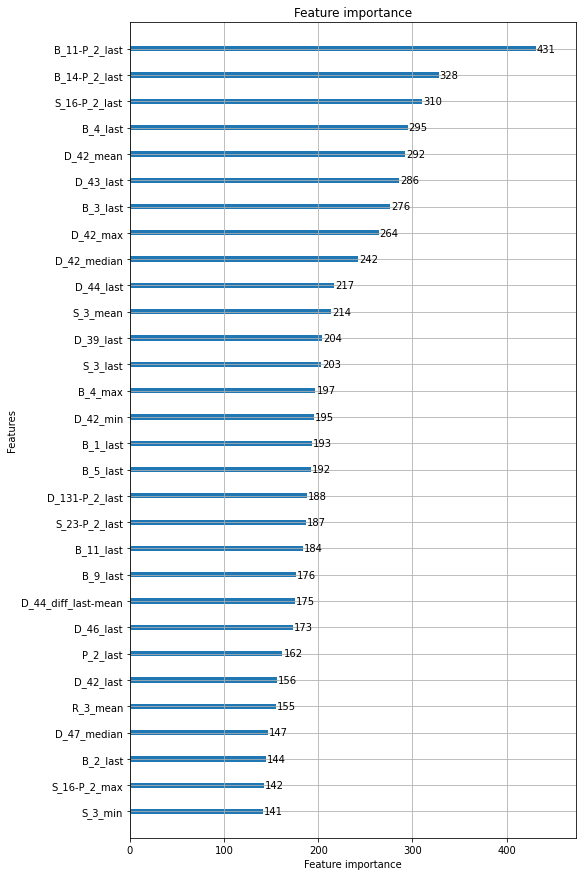

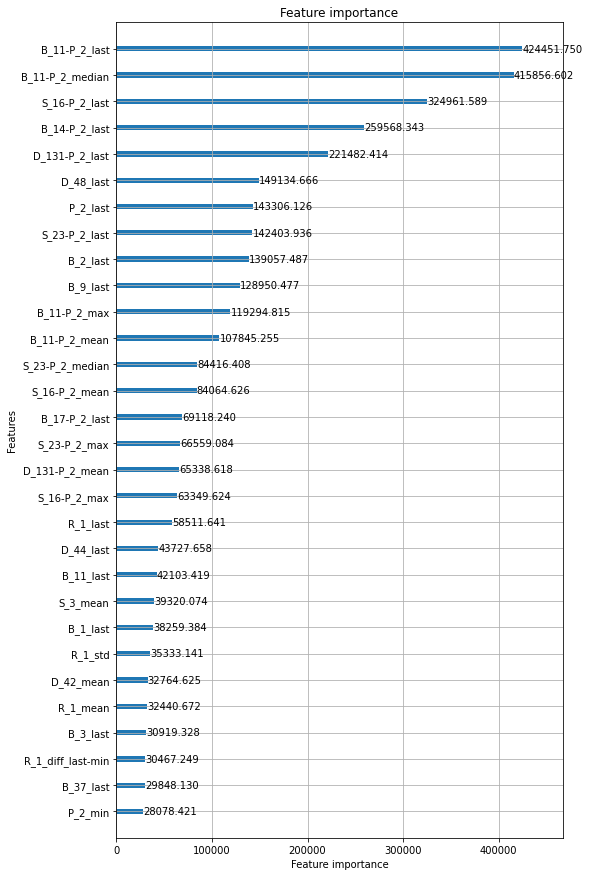

######################################## training model 3/5 ########################################


[50]	valid_0's amex_metric: 0.752286	valid_0's recall_at4: 0.605066	valid_0's norm_gini: 0.899507


[100]	valid_0's amex_metric: 0.763262	valid_0's recall_at4: 0.621097	valid_0's norm_gini: 0.905427


[150]	valid_0's amex_metric: 0.769932	valid_0's recall_at4: 0.630523	valid_0's norm_gini: 0.909342


[200]	valid_0's amex_metric: 0.77586	valid_0's recall_at4: 0.638686	valid_0's norm_gini: 0.913034


[250]	valid_0's amex_metric: 0.778869	valid_0's recall_at4: 0.642346	valid_0's norm_gini: 0.915391


[300]	valid_0's amex_metric: 0.781566	valid_0's recall_at4: 0.646007	valid_0's norm_gini: 0.917124


[350]	valid_0's amex_metric: 0.784828	valid_0's recall_at4: 0.651182	valid_0's norm_gini: 0.918474


[400]	valid_0's amex_metric: 0.786543	valid_0's recall_at4: 0.653539	valid_0's norm_gini: 0.919548


[450]	valid_0's amex_metric: 0.788382	valid_0's recall_at4: 0.656442	valid_0's norm_gini: 0.920323


[500]	valid_0's amex_metric: 0.789856	valid_0's recall_at4: 0.658798	valid_0's norm_gini: 0.920913


[550]	valid_0's amex_metric: 0.790468	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.921423


[600]	valid_0's amex_metric: 0.790947	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.921749


[650]	valid_0's amex_metric: 0.792375	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.922122


[700]	valid_0's amex_metric: 0.793031	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.922425


[750]	valid_0's amex_metric: 0.793434	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.922684


[800]	valid_0's amex_metric: 0.793583	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.922897


[850]	valid_0's amex_metric: 0.794078	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.923173


[900]	valid_0's amex_metric: 0.794638	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.923325


[950]	valid_0's amex_metric: 0.794511	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.923617


[1000]	valid_0's amex_metric: 0.795918	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.923865


[1050]	valid_0's amex_metric: 0.796483	valid_0's recall_at4: 0.668855	valid_0's norm_gini: 0.924112


[1100]	valid_0's amex_metric: 0.797361	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.924353


[1150]	valid_0's amex_metric: 0.79807	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.924509


[1200]	valid_0's amex_metric: 0.798467	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.92463


[1250]	valid_0's amex_metric: 0.798631	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.924704


[1300]	valid_0's amex_metric: 0.799095	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.92479


[1350]	valid_0's amex_metric: 0.799119	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.924839


[1400]	valid_0's amex_metric: 0.799173	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.924946


[1450]	valid_0's amex_metric: 0.799258	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.925033


[1500]	valid_0's amex_metric: 0.799377	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.925144


[1550]	valid_0's amex_metric: 0.799209	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.92523


[1600]	valid_0's amex_metric: 0.799079	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.925263


[1650]	valid_0's amex_metric: 0.799618	valid_0's recall_at4: 0.673904	valid_0's norm_gini: 0.925332


[1700]	valid_0's amex_metric: 0.799264	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.925381


[1750]	valid_0's amex_metric: 0.798997	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925437


[1800]	valid_0's amex_metric: 0.799378	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.925484


[1850]	valid_0's amex_metric: 0.799259	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.925498


[1900]	valid_0's amex_metric: 0.798905	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.925505


[1950]	valid_0's amex_metric: 0.799062	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925566


[2000]	valid_0's amex_metric: 0.798858	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.925579


[2050]	valid_0's amex_metric: 0.798784	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.925599


[2100]	valid_0's amex_metric: 0.798925	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.92563


[2150]	valid_0's amex_metric: 0.798543	valid_0's recall_at4: 0.671421	valid_0's norm_gini: 0.925665


[2200]	valid_0's amex_metric: 0.79898	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.925698


[2250]	valid_0's amex_metric: 0.7991	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.925727


[2300]	valid_0's amex_metric: 0.799425	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.925745


[2350]	valid_0's amex_metric: 0.799622	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.92576


[2400]	valid_0's amex_metric: 0.799588	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.925778


[2450]	valid_0's amex_metric: 0.799474	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.925802


[2500]	valid_0's amex_metric: 0.79931	valid_0's recall_at4: 0.67281	valid_0's norm_gini: 0.925811


[2550]	valid_0's amex_metric: 0.799139	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.925806


[2600]	valid_0's amex_metric: 0.799097	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.925804


[2650]	valid_0's amex_metric: 0.799375	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.925814


[2700]	valid_0's amex_metric: 0.799648	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.925813


[2750]	valid_0's amex_metric: 0.799384	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.925832


[2800]	valid_0's amex_metric: 0.799423	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.925826


[2850]	valid_0's amex_metric: 0.798965	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.925836


[2900]	valid_0's amex_metric: 0.799446	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.92583


[2950]	valid_0's amex_metric: 0.799297	valid_0's recall_at4: 0.672768	valid_0's norm_gini: 0.925827


[3000]	valid_0's amex_metric: 0.799382	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.925871


[3050]	valid_0's amex_metric: 0.79894	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.92587


[3100]	valid_0's amex_metric: 0.799204	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.925893


[3150]	valid_0's amex_metric: 0.799021	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.925906


[3200]	valid_0's amex_metric: 0.799168	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.925946


[3250]	valid_0's amex_metric: 0.799253	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925949


[3300]	valid_0's amex_metric: 0.799668	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.925937


[3350]	valid_0's amex_metric: 0.799662	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.925925


[3400]	valid_0's amex_metric: 0.799384	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.925916


[3450]	valid_0's amex_metric: 0.798898	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.925911


[3500]	valid_0's amex_metric: 0.7993	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.925917


[3550]	valid_0's amex_metric: 0.799224	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.925933


[3600]	valid_0's amex_metric: 0.799223	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.925931


[3650]	valid_0's amex_metric: 0.799075	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.925928


[3700]	valid_0's amex_metric: 0.798982	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.925911


[3750]	valid_0's amex_metric: 0.798922	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925918


[3800]	valid_0's amex_metric: 0.798968	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.925925


[3850]	valid_0's amex_metric: 0.79926	valid_0's recall_at4: 0.672599	valid_0's norm_gini: 0.92592


[3900]	valid_0's amex_metric: 0.798518	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.92591


[3950]	valid_0's amex_metric: 0.799125	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.925903


[4000]	valid_0's amex_metric: 0.798933	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.925897


[4050]	valid_0's amex_metric: 0.798849	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.925897


[4100]	valid_0's amex_metric: 0.798873	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.925904


[4150]	valid_0's amex_metric: 0.799063	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.925906


[4200]	valid_0's amex_metric: 0.798805	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925895


[4250]	valid_0's amex_metric: 0.79918	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.925888


[4300]	valid_0's amex_metric: 0.799225	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925893


[4350]	valid_0's amex_metric: 0.79952	valid_0's recall_at4: 0.673146	valid_0's norm_gini: 0.925893


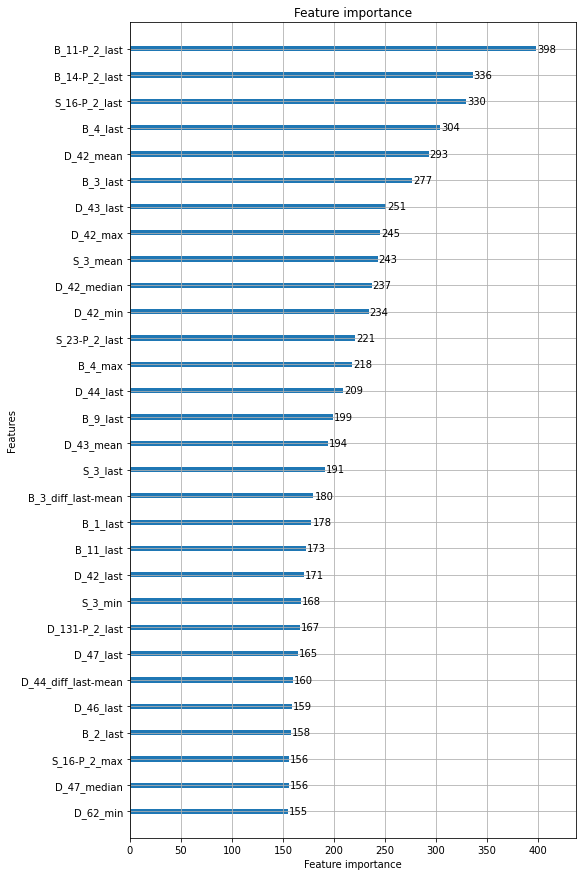

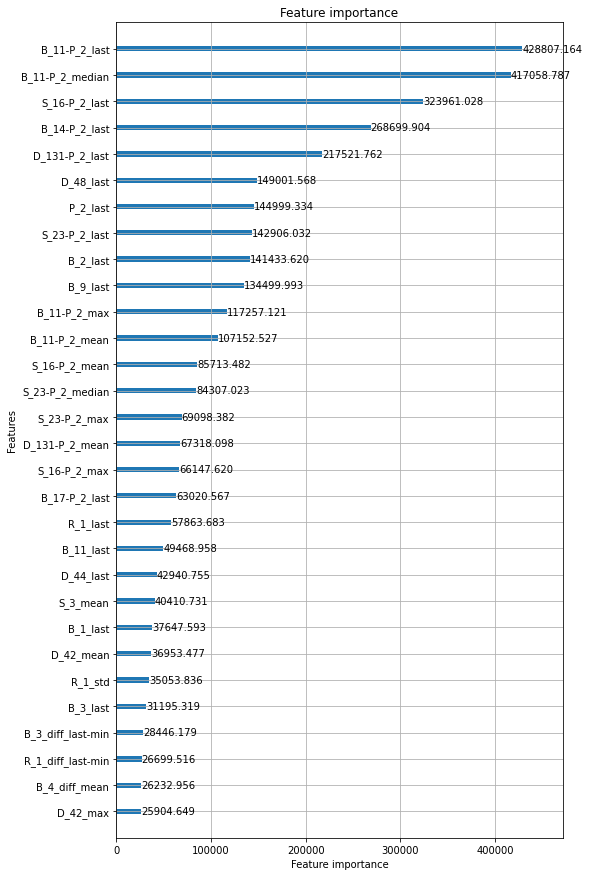

######################################## training model 4/5 ########################################


[50]	valid_0's amex_metric: 0.755544	valid_0's recall_at4: 0.607027	valid_0's norm_gini: 0.904061


[100]	valid_0's amex_metric: 0.766057	valid_0's recall_at4: 0.623017	valid_0's norm_gini: 0.909097


[150]	valid_0's amex_metric: 0.771999	valid_0's recall_at4: 0.631349	valid_0's norm_gini: 0.91265


[200]	valid_0's amex_metric: 0.780146	valid_0's recall_at4: 0.643888	valid_0's norm_gini: 0.916404


[250]	valid_0's amex_metric: 0.783171	valid_0's recall_at4: 0.647717	valid_0's norm_gini: 0.918624


[300]	valid_0's amex_metric: 0.786486	valid_0's recall_at4: 0.65264	valid_0's norm_gini: 0.920331


[350]	valid_0's amex_metric: 0.789065	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.921535


[400]	valid_0's amex_metric: 0.791025	valid_0's recall_at4: 0.659499	valid_0's norm_gini: 0.922552


[450]	valid_0's amex_metric: 0.792467	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.923288


[500]	valid_0's amex_metric: 0.794078	valid_0's recall_at4: 0.664338	valid_0's norm_gini: 0.923817


[550]	valid_0's amex_metric: 0.795095	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.924337


[600]	valid_0's amex_metric: 0.795657	valid_0's recall_at4: 0.666611	valid_0's norm_gini: 0.924704


[650]	valid_0's amex_metric: 0.796676	valid_0's recall_at4: 0.668294	valid_0's norm_gini: 0.925059


[700]	valid_0's amex_metric: 0.796448	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.92536


[750]	valid_0's amex_metric: 0.798152	valid_0's recall_at4: 0.670692	valid_0's norm_gini: 0.925612


[800]	valid_0's amex_metric: 0.798241	valid_0's recall_at4: 0.670692	valid_0's norm_gini: 0.92579


[850]	valid_0's amex_metric: 0.799518	valid_0's recall_at4: 0.672964	valid_0's norm_gini: 0.926071


[900]	valid_0's amex_metric: 0.79977	valid_0's recall_at4: 0.673301	valid_0's norm_gini: 0.926238


[950]	valid_0's amex_metric: 0.800636	valid_0's recall_at4: 0.674816	valid_0's norm_gini: 0.926456


[1000]	valid_0's amex_metric: 0.80081	valid_0's recall_at4: 0.674942	valid_0's norm_gini: 0.926678


[1050]	valid_0's amex_metric: 0.801282	valid_0's recall_at4: 0.675657	valid_0's norm_gini: 0.926906


[1100]	valid_0's amex_metric: 0.801961	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.927128


[1150]	valid_0's amex_metric: 0.801922	valid_0's recall_at4: 0.676583	valid_0's norm_gini: 0.92726


[1200]	valid_0's amex_metric: 0.801891	valid_0's recall_at4: 0.676415	valid_0's norm_gini: 0.927366


[1250]	valid_0's amex_metric: 0.802625	valid_0's recall_at4: 0.677761	valid_0's norm_gini: 0.927488


[1300]	valid_0's amex_metric: 0.802854	valid_0's recall_at4: 0.67814	valid_0's norm_gini: 0.927568


[1350]	valid_0's amex_metric: 0.80325	valid_0's recall_at4: 0.678855	valid_0's norm_gini: 0.927644


[1400]	valid_0's amex_metric: 0.803524	valid_0's recall_at4: 0.679318	valid_0's norm_gini: 0.927729


[1450]	valid_0's amex_metric: 0.803882	valid_0's recall_at4: 0.67995	valid_0's norm_gini: 0.927815


[1500]	valid_0's amex_metric: 0.803388	valid_0's recall_at4: 0.678855	valid_0's norm_gini: 0.92792


[1550]	valid_0's amex_metric: 0.803597	valid_0's recall_at4: 0.679192	valid_0's norm_gini: 0.928001


[1600]	valid_0's amex_metric: 0.80411	valid_0's recall_at4: 0.68016	valid_0's norm_gini: 0.92806


[1650]	valid_0's amex_metric: 0.804406	valid_0's recall_at4: 0.680707	valid_0's norm_gini: 0.928105


[1700]	valid_0's amex_metric: 0.804892	valid_0's recall_at4: 0.681633	valid_0's norm_gini: 0.928151


[1750]	valid_0's amex_metric: 0.804951	valid_0's recall_at4: 0.681675	valid_0's norm_gini: 0.928228


[1800]	valid_0's amex_metric: 0.804614	valid_0's recall_at4: 0.680959	valid_0's norm_gini: 0.928268


[1850]	valid_0's amex_metric: 0.804887	valid_0's recall_at4: 0.681464	valid_0's norm_gini: 0.928311


[1900]	valid_0's amex_metric: 0.805365	valid_0's recall_at4: 0.68239	valid_0's norm_gini: 0.928339


[1950]	valid_0's amex_metric: 0.805124	valid_0's recall_at4: 0.681843	valid_0's norm_gini: 0.928404


[2000]	valid_0's amex_metric: 0.805289	valid_0's recall_at4: 0.682138	valid_0's norm_gini: 0.928441


[2050]	valid_0's amex_metric: 0.804814	valid_0's recall_at4: 0.68117	valid_0's norm_gini: 0.928458


[2100]	valid_0's amex_metric: 0.804439	valid_0's recall_at4: 0.68037	valid_0's norm_gini: 0.928508


[2150]	valid_0's amex_metric: 0.804582	valid_0's recall_at4: 0.680623	valid_0's norm_gini: 0.928542


[2200]	valid_0's amex_metric: 0.805284	valid_0's recall_at4: 0.681969	valid_0's norm_gini: 0.928598


[2250]	valid_0's amex_metric: 0.804924	valid_0's recall_at4: 0.681212	valid_0's norm_gini: 0.928637


[2300]	valid_0's amex_metric: 0.805017	valid_0's recall_at4: 0.68138	valid_0's norm_gini: 0.928653


[2350]	valid_0's amex_metric: 0.80547	valid_0's recall_at4: 0.682264	valid_0's norm_gini: 0.928675


[2400]	valid_0's amex_metric: 0.805273	valid_0's recall_at4: 0.681843	valid_0's norm_gini: 0.928703


[2450]	valid_0's amex_metric: 0.805093	valid_0's recall_at4: 0.681464	valid_0's norm_gini: 0.928721


[2500]	valid_0's amex_metric: 0.804862	valid_0's recall_at4: 0.681001	valid_0's norm_gini: 0.928722


[2550]	valid_0's amex_metric: 0.805199	valid_0's recall_at4: 0.681675	valid_0's norm_gini: 0.928724


[2600]	valid_0's amex_metric: 0.805206	valid_0's recall_at4: 0.681675	valid_0's norm_gini: 0.928738


[2650]	valid_0's amex_metric: 0.805004	valid_0's recall_at4: 0.681254	valid_0's norm_gini: 0.928754


[2700]	valid_0's amex_metric: 0.805228	valid_0's recall_at4: 0.681675	valid_0's norm_gini: 0.928781


[2750]	valid_0's amex_metric: 0.80486	valid_0's recall_at4: 0.680917	valid_0's norm_gini: 0.928802


[2800]	valid_0's amex_metric: 0.804949	valid_0's recall_at4: 0.681086	valid_0's norm_gini: 0.928813


[2850]	valid_0's amex_metric: 0.805235	valid_0's recall_at4: 0.681633	valid_0's norm_gini: 0.928836


[2900]	valid_0's amex_metric: 0.805008	valid_0's recall_at4: 0.68117	valid_0's norm_gini: 0.928847


[2950]	valid_0's amex_metric: 0.804925	valid_0's recall_at4: 0.681001	valid_0's norm_gini: 0.928849


[3000]	valid_0's amex_metric: 0.804927	valid_0's recall_at4: 0.681001	valid_0's norm_gini: 0.928853


[3050]	valid_0's amex_metric: 0.805136	valid_0's recall_at4: 0.681422	valid_0's norm_gini: 0.928849


[3100]	valid_0's amex_metric: 0.804527	valid_0's recall_at4: 0.680202	valid_0's norm_gini: 0.928852


[3150]	valid_0's amex_metric: 0.804548	valid_0's recall_at4: 0.680244	valid_0's norm_gini: 0.928853


[3200]	valid_0's amex_metric: 0.80497	valid_0's recall_at4: 0.681086	valid_0's norm_gini: 0.928854


[3250]	valid_0's amex_metric: 0.805159	valid_0's recall_at4: 0.681464	valid_0's norm_gini: 0.928853


[3300]	valid_0's amex_metric: 0.805331	valid_0's recall_at4: 0.681801	valid_0's norm_gini: 0.928862


[3350]	valid_0's amex_metric: 0.805335	valid_0's recall_at4: 0.681801	valid_0's norm_gini: 0.928869


[3400]	valid_0's amex_metric: 0.805308	valid_0's recall_at4: 0.681759	valid_0's norm_gini: 0.928858


[3450]	valid_0's amex_metric: 0.80534	valid_0's recall_at4: 0.681843	valid_0's norm_gini: 0.928836


[3500]	valid_0's amex_metric: 0.804825	valid_0's recall_at4: 0.680791	valid_0's norm_gini: 0.928859


[3550]	valid_0's amex_metric: 0.804739	valid_0's recall_at4: 0.680623	valid_0's norm_gini: 0.928856


[3600]	valid_0's amex_metric: 0.804939	valid_0's recall_at4: 0.681001	valid_0's norm_gini: 0.928877


[3650]	valid_0's amex_metric: 0.805274	valid_0's recall_at4: 0.681675	valid_0's norm_gini: 0.928874


[3700]	valid_0's amex_metric: 0.804983	valid_0's recall_at4: 0.681086	valid_0's norm_gini: 0.92888


[3750]	valid_0's amex_metric: 0.805175	valid_0's recall_at4: 0.681464	valid_0's norm_gini: 0.928886


[3800]	valid_0's amex_metric: 0.805553	valid_0's recall_at4: 0.682222	valid_0's norm_gini: 0.928885


[3850]	valid_0's amex_metric: 0.805678	valid_0's recall_at4: 0.682474	valid_0's norm_gini: 0.928882


[3900]	valid_0's amex_metric: 0.805653	valid_0's recall_at4: 0.682432	valid_0's norm_gini: 0.928874


[3950]	valid_0's amex_metric: 0.805509	valid_0's recall_at4: 0.682138	valid_0's norm_gini: 0.92888


[4000]	valid_0's amex_metric: 0.805466	valid_0's recall_at4: 0.682053	valid_0's norm_gini: 0.928878


[4050]	valid_0's amex_metric: 0.805497	valid_0's recall_at4: 0.682138	valid_0's norm_gini: 0.928855


[4100]	valid_0's amex_metric: 0.805497	valid_0's recall_at4: 0.682138	valid_0's norm_gini: 0.928856


[4150]	valid_0's amex_metric: 0.805246	valid_0's recall_at4: 0.681633	valid_0's norm_gini: 0.928859


[4200]	valid_0's amex_metric: 0.805247	valid_0's recall_at4: 0.681633	valid_0's norm_gini: 0.928862


[4250]	valid_0's amex_metric: 0.804724	valid_0's recall_at4: 0.680581	valid_0's norm_gini: 0.928867


[4300]	valid_0's amex_metric: 0.804828	valid_0's recall_at4: 0.680791	valid_0's norm_gini: 0.928865


[4350]	valid_0's amex_metric: 0.804837	valid_0's recall_at4: 0.680791	valid_0's norm_gini: 0.928883


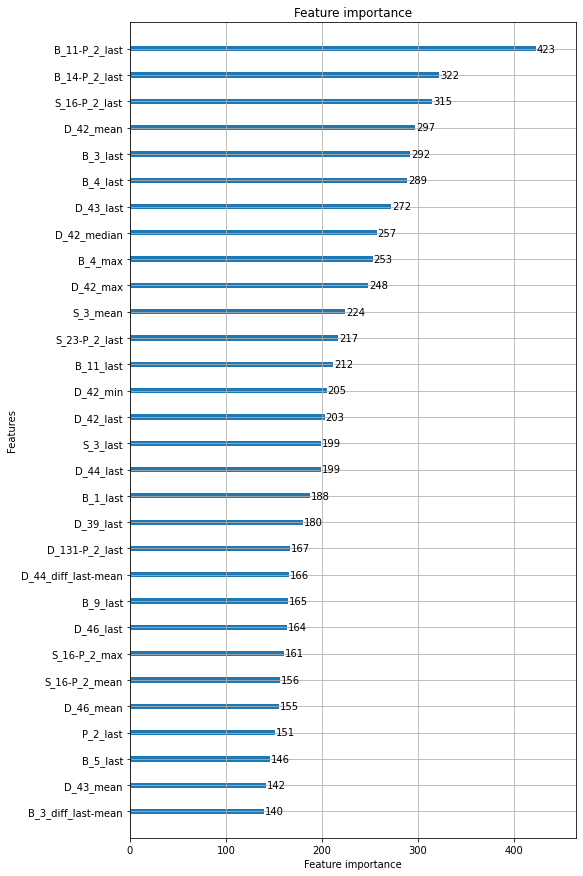

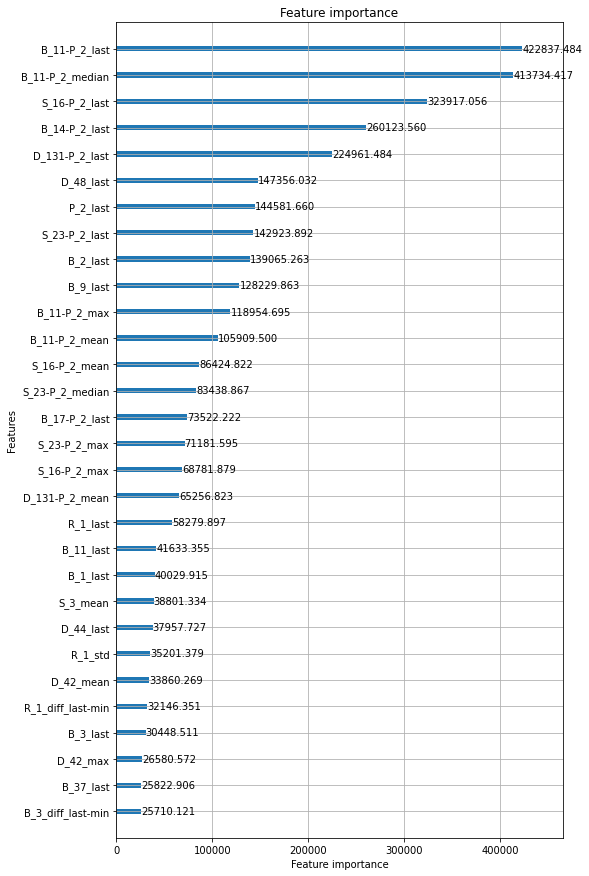

######################################## training model 5/5 ########################################


[50]	valid_0's amex_metric: 0.753098	valid_0's recall_at4: 0.606101	valid_0's norm_gini: 0.900095


[100]	valid_0's amex_metric: 0.761629	valid_0's recall_at4: 0.617968	valid_0's norm_gini: 0.90529


[150]	valid_0's amex_metric: 0.767663	valid_0's recall_at4: 0.626215	valid_0's norm_gini: 0.909111


[200]	valid_0's amex_metric: 0.773115	valid_0's recall_at4: 0.633663	valid_0's norm_gini: 0.912567


[250]	valid_0's amex_metric: 0.777548	valid_0's recall_at4: 0.640227	valid_0's norm_gini: 0.91487


[300]	valid_0's amex_metric: 0.780371	valid_0's recall_at4: 0.644267	valid_0's norm_gini: 0.916475


[350]	valid_0's amex_metric: 0.78222	valid_0's recall_at4: 0.646749	valid_0's norm_gini: 0.91769


[400]	valid_0's amex_metric: 0.783956	valid_0's recall_at4: 0.649232	valid_0's norm_gini: 0.918679


[450]	valid_0's amex_metric: 0.785508	valid_0's recall_at4: 0.651631	valid_0's norm_gini: 0.919386


[500]	valid_0's amex_metric: 0.786108	valid_0's recall_at4: 0.652304	valid_0's norm_gini: 0.919913


[550]	valid_0's amex_metric: 0.786708	valid_0's recall_at4: 0.653061	valid_0's norm_gini: 0.920354


[600]	valid_0's amex_metric: 0.786589	valid_0's recall_at4: 0.652472	valid_0's norm_gini: 0.920705


[650]	valid_0's amex_metric: 0.787775	valid_0's recall_at4: 0.654492	valid_0's norm_gini: 0.921057


[700]	valid_0's amex_metric: 0.788152	valid_0's recall_at4: 0.654913	valid_0's norm_gini: 0.921392


[750]	valid_0's amex_metric: 0.788902	valid_0's recall_at4: 0.656175	valid_0's norm_gini: 0.92163


[800]	valid_0's amex_metric: 0.788789	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.921824


[850]	valid_0's amex_metric: 0.789331	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.922066


[900]	valid_0's amex_metric: 0.789313	valid_0's recall_at4: 0.656385	valid_0's norm_gini: 0.92224


[950]	valid_0's amex_metric: 0.790064	valid_0's recall_at4: 0.657648	valid_0's norm_gini: 0.922481


[1000]	valid_0's amex_metric: 0.790566	valid_0's recall_at4: 0.658447	valid_0's norm_gini: 0.922684


[1050]	valid_0's amex_metric: 0.7918	valid_0's recall_at4: 0.660677	valid_0's norm_gini: 0.922922


[1100]	valid_0's amex_metric: 0.791212	valid_0's recall_at4: 0.659289	valid_0's norm_gini: 0.923136


[1150]	valid_0's amex_metric: 0.791594	valid_0's recall_at4: 0.65992	valid_0's norm_gini: 0.923268


[1200]	valid_0's amex_metric: 0.792131	valid_0's recall_at4: 0.660888	valid_0's norm_gini: 0.923374


[1250]	valid_0's amex_metric: 0.791715	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.923468


[1300]	valid_0's amex_metric: 0.791811	valid_0's recall_at4: 0.660046	valid_0's norm_gini: 0.923576


[1350]	valid_0's amex_metric: 0.792591	valid_0's recall_at4: 0.661519	valid_0's norm_gini: 0.923663


[1400]	valid_0's amex_metric: 0.792702	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.923759


[1450]	valid_0's amex_metric: 0.792523	valid_0's recall_at4: 0.661224	valid_0's norm_gini: 0.923821


[1500]	valid_0's amex_metric: 0.793032	valid_0's recall_at4: 0.66215	valid_0's norm_gini: 0.923913


[1550]	valid_0's amex_metric: 0.793661	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.923994


[1600]	valid_0's amex_metric: 0.7934	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.92406


[1650]	valid_0's amex_metric: 0.793576	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.924119


[1700]	valid_0's amex_metric: 0.793625	valid_0's recall_at4: 0.663076	valid_0's norm_gini: 0.924175


[1750]	valid_0's amex_metric: 0.793485	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.92423


[1800]	valid_0's amex_metric: 0.793482	valid_0's recall_at4: 0.662697	valid_0's norm_gini: 0.924266


[1850]	valid_0's amex_metric: 0.794068	valid_0's recall_at4: 0.663833	valid_0's norm_gini: 0.924303


[1900]	valid_0's amex_metric: 0.793832	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.924336


[1950]	valid_0's amex_metric: 0.793879	valid_0's recall_at4: 0.66337	valid_0's norm_gini: 0.924388


[2000]	valid_0's amex_metric: 0.794176	valid_0's recall_at4: 0.663918	valid_0's norm_gini: 0.924435


[2050]	valid_0's amex_metric: 0.79437	valid_0's recall_at4: 0.664296	valid_0's norm_gini: 0.924443


[2100]	valid_0's amex_metric: 0.793576	valid_0's recall_at4: 0.662655	valid_0's norm_gini: 0.924497


[2150]	valid_0's amex_metric: 0.794353	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924536


[2200]	valid_0's amex_metric: 0.794233	valid_0's recall_at4: 0.663918	valid_0's norm_gini: 0.924549


[2250]	valid_0's amex_metric: 0.794371	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924573


[2300]	valid_0's amex_metric: 0.794142	valid_0's recall_at4: 0.663707	valid_0's norm_gini: 0.924578


[2350]	valid_0's amex_metric: 0.7939	valid_0's recall_at4: 0.663202	valid_0's norm_gini: 0.924598


[2400]	valid_0's amex_metric: 0.793761	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.924614


[2450]	valid_0's amex_metric: 0.794446	valid_0's recall_at4: 0.664254	valid_0's norm_gini: 0.924639


[2500]	valid_0's amex_metric: 0.79431	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.924661


[2550]	valid_0's amex_metric: 0.795061	valid_0's recall_at4: 0.665432	valid_0's norm_gini: 0.92469


[2600]	valid_0's amex_metric: 0.794576	valid_0's recall_at4: 0.664465	valid_0's norm_gini: 0.924688


[2650]	valid_0's amex_metric: 0.794852	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.924692


[2700]	valid_0's amex_metric: 0.794805	valid_0's recall_at4: 0.664927	valid_0's norm_gini: 0.924683


[2750]	valid_0's amex_metric: 0.794906	valid_0's recall_at4: 0.665138	valid_0's norm_gini: 0.924674


[2800]	valid_0's amex_metric: 0.794666	valid_0's recall_at4: 0.664633	valid_0's norm_gini: 0.924699


[2850]	valid_0's amex_metric: 0.795085	valid_0's recall_at4: 0.665432	valid_0's norm_gini: 0.924738


[2900]	valid_0's amex_metric: 0.795237	valid_0's recall_at4: 0.665727	valid_0's norm_gini: 0.924747


[2950]	valid_0's amex_metric: 0.795069	valid_0's recall_at4: 0.66539	valid_0's norm_gini: 0.924747


[3000]	valid_0's amex_metric: 0.79544	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.924774


[3050]	valid_0's amex_metric: 0.795171	valid_0's recall_at4: 0.665559	valid_0's norm_gini: 0.924783


[3100]	valid_0's amex_metric: 0.795262	valid_0's recall_at4: 0.665727	valid_0's norm_gini: 0.924797


[3150]	valid_0's amex_metric: 0.795221	valid_0's recall_at4: 0.665601	valid_0's norm_gini: 0.924842


[3200]	valid_0's amex_metric: 0.795438	valid_0's recall_at4: 0.666021	valid_0's norm_gini: 0.924854


[3250]	valid_0's amex_metric: 0.795335	valid_0's recall_at4: 0.665811	valid_0's norm_gini: 0.924859


[3300]	valid_0's amex_metric: 0.794894	valid_0's recall_at4: 0.664927	valid_0's norm_gini: 0.924861


[3350]	valid_0's amex_metric: 0.795353	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.924853


[3400]	valid_0's amex_metric: 0.795455	valid_0's recall_at4: 0.666064	valid_0's norm_gini: 0.924846


[3450]	valid_0's amex_metric: 0.795611	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.924864


[3500]	valid_0's amex_metric: 0.795313	valid_0's recall_at4: 0.665769	valid_0's norm_gini: 0.924857


[3550]	valid_0's amex_metric: 0.795021	valid_0's recall_at4: 0.66518	valid_0's norm_gini: 0.924861


[3600]	valid_0's amex_metric: 0.795052	valid_0's recall_at4: 0.665222	valid_0's norm_gini: 0.924881


[3650]	valid_0's amex_metric: 0.79543	valid_0's recall_at4: 0.665979	valid_0's norm_gini: 0.92488


[3700]	valid_0's amex_metric: 0.795561	valid_0's recall_at4: 0.666232	valid_0's norm_gini: 0.924891


[3750]	valid_0's amex_metric: 0.794943	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.924875


[3800]	valid_0's amex_metric: 0.795088	valid_0's recall_at4: 0.665306	valid_0's norm_gini: 0.92487


[3850]	valid_0's amex_metric: 0.794372	valid_0's recall_at4: 0.663875	valid_0's norm_gini: 0.924868


[3900]	valid_0's amex_metric: 0.794643	valid_0's recall_at4: 0.664422	valid_0's norm_gini: 0.924863


[3950]	valid_0's amex_metric: 0.7941	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.924872


[4000]	valid_0's amex_metric: 0.794269	valid_0's recall_at4: 0.663665	valid_0's norm_gini: 0.924872


[4050]	valid_0's amex_metric: 0.794367	valid_0's recall_at4: 0.663875	valid_0's norm_gini: 0.924858


[4100]	valid_0's amex_metric: 0.793889	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.924871


[4150]	valid_0's amex_metric: 0.794268	valid_0's recall_at4: 0.663665	valid_0's norm_gini: 0.924872


[4200]	valid_0's amex_metric: 0.794361	valid_0's recall_at4: 0.663875	valid_0's norm_gini: 0.924847


[4250]	valid_0's amex_metric: 0.794195	valid_0's recall_at4: 0.663539	valid_0's norm_gini: 0.924852


[4300]	valid_0's amex_metric: 0.794241	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.92486


[4350]	valid_0's amex_metric: 0.794089	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.92485


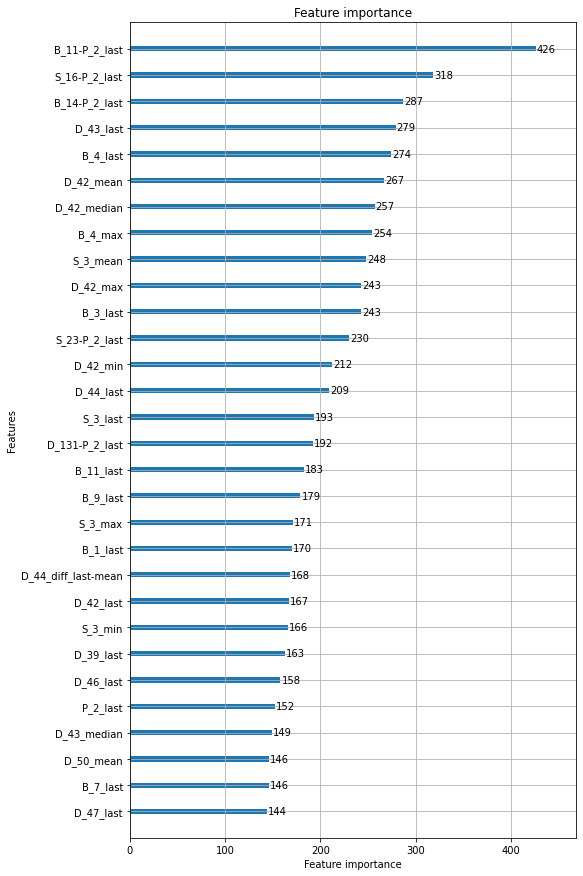

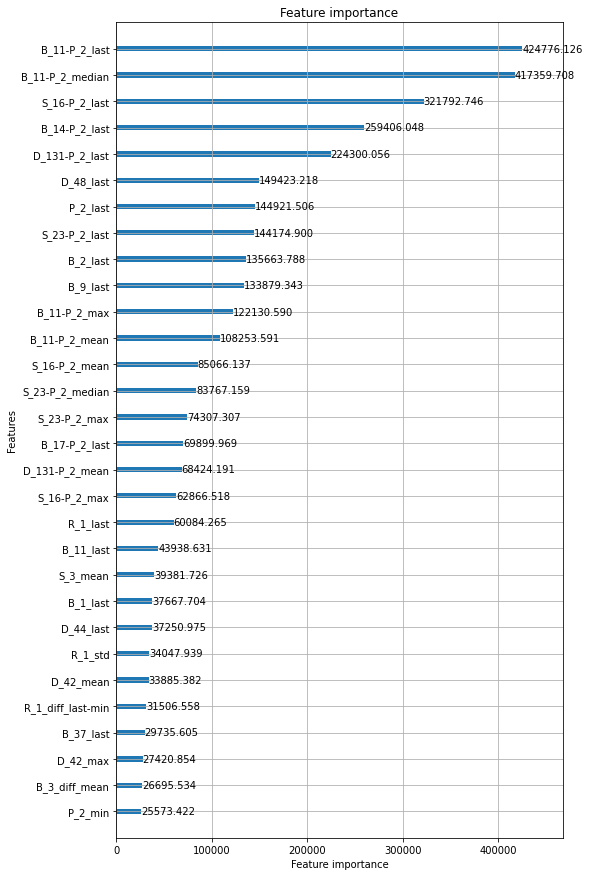

Training time: 48.12412475744883 min.
OOF recall_at4: 0.6694381795536406
OOF normalized_gini: 0.9258215577683003
OOF competition metric: 0.7976298686609704


CPU times: user 1d 12h 47min 8s, sys: 2min 1s, total: 1d 12h 49min 10s
Wall time: 2h 24min 19s


In [11]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_models.append(models)
    all_oof_dfs.append(oof)
    
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"/model-cv{repetition}-fold{fold}.txt")
          
    del _train, folds; gc.collect()

In [12]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.669867,0.925872,0.797869
1,0.670650,0.925902,0.798276
2,0.669438,0.925822,0.797630



mean:


recall_at4    0.669985
gini          0.925865
metric        0.797925
dtype: float64


std:


recall_at4    0.000614
gini          0.000041
metric        0.000327
dtype: float64

In [13]:
del train
gc.collect()

21

***
## make predictions and submit

In [14]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)    

In [15]:
test = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [16]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

CPU times: user 1h 47min 22s, sys: 1min 2s, total: 1h 48min 24s
Wall time: 8min 17s


In [17]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

CPU times: user 3.67 s, sys: 990 ms, total: 4.66 s
Wall time: 4.66 s


***